## 모듈

In [68]:
import mysql.connector
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import rc
import math
%matplotlib inline
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15) 

In [2]:
dotenv_path = "../.env"
load_dotenv(dotenv_path)

db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

conn = mysql.connector.connect(
    host = db_host,
    port = db_port,
    database = db_name,
    user = db_user,
    password = db_password
)

mycursor = conn.cursor()

def show_sql_result(sql):
       mycursor.execute(sql)
       rows = mycursor.fetchall()
       columns = [column[0] for column in mycursor.description]
       table_data = pd.DataFrame(rows, columns=columns)
       return table_data

In [16]:
sql = '''
WITH CustomerCategorySpend AS (
    SELECT
        CustomerID,
        ProductCategory,
        SUM(AverageAmount * Quantity) AS CategorySpend
    FROM
        sales
    GROUP BY
        CustomerID, ProductCategory
),
RankedCustomerCategory AS (
    SELECT
        CustomerID,
        ProductCategory,
        CategorySpend,
        RANK() OVER (PARTITION BY CustomerID ORDER BY CategorySpend DESC) AS SpendRank
    FROM
        CustomerCategorySpend
)
SELECT
    cs.CustomerID,
    COUNT(DISTINCT cs.TransactionID) AS 구매건수,
    AVG(NULLIF(cs.구매간격, 0)) AS 평균구매간격,
    COUNT(DISTINCT cs.TransactionDate) AS 구매발생일수,
    DATEDIFF('2019-12-31', MAX(cs.TransactionDate)) + 1 AS Recency,
    SUM(cs.Quantity) AS 총구매수량,
    AVG(cs.AverageAmount) AS 구입상품_평균가격,
    SUM(cs.AverageAmount * cs.Quantity) AS 총지출액,
    rcc.ProductCategory AS 최대지출_카테고리
FROM(
    SELECT
        CustomerID,
        TransactionID,
        TransactionDate,
        AverageAmount,
        Quantity,
        CASE 
            WHEN DATEDIFF(LEAD(TransactionDate) OVER (PARTITION BY CustomerID ORDER BY TransactionDate), TransactionDate) = 0 THEN 0
            ELSE DATEDIFF(LEAD(TransactionDate) OVER (PARTITION BY CustomerID ORDER BY TransactionDate), TransactionDate)
        END AS 구매간격
    FROM
        sales
) AS cs
JOIN
    RankedCustomerCategory rcc ON cs.CustomerID = rcc.CustomerID AND rcc.SpendRank = 1
GROUP BY
    CustomerID
;
'''
data = show_sql_result(sql)
data

CustomerID  구매건수    평균구매간격  구매발생일수  Recency 총구매수량   구입상품_평균가격      총지출액  \
0     USER_0000     1      None       1      108     3   12.745000     30.99   
1     USER_0001    31  111.5000       3       60   342   62.436000  13834.90   
2     USER_0002     8  119.0000       2       74   209   14.631304   1442.12   
3     USER_0003    11      None       1       18    21   77.200000   1360.07   
4     USER_0004    13      None       1      108    56   34.578611   1442.47   
...         ...   ...       ...     ...      ...   ...         ...       ...   
1463  USER_1463     3      None       1      271    46   12.104286    544.34   
1464  USER_1464    19   52.5000       3       88   141   27.872250   2363.05   
1465  USER_1465     2   76.0000       2      195    10   11.167500    101.56   
1466  USER_1466     1      None       1       70     2  149.000000    298.00   
1467  USER_1467    53   73.0000       2       83   155   55.470588   6362.77   

                 최대지출_카테고리  
0                  Apparel  
1                  Apparel  
2                 Nest-USA  
3                 Nest-USA  
4                 Nest-USA  
...                    ...  
1463  Notebooks & Journals  
1464              Nest-USA  
1465               Apparel  
1466              Nest-USA  
1467              Nest-USA  

[1468 rows x 9 columns]

## 입력 데이터 생성

In [9]:
sql = '''
SELECT
    CustomerID,
    COUNT(DISTINCT ProductID) AS 구매제품_종류
FROM
    sales
GROUP BY
    CustomerID
;
'''
data2 = show_sql_result(sql)
data2

CustomerID  구매제품_종류
0     USER_0000        2
1     USER_0001       42
2     USER_0002       21
3     USER_0003       11
4     USER_0004       33
...         ...      ...
1463  USER_1463        7
1464  USER_1464       35
1465  USER_1465        8
1466  USER_1466        1
1467  USER_1467       69

[1468 rows x 2 columns]

In [20]:
df_input = pd.merge(left=data, right=data2, on='CustomerID')
df_input

CustomerID  구매건수    평균구매간격  구매발생일수  Recency 총구매수량   구입상품_평균가격      총지출액  \
0     USER_0000     1      None       1      108     3   12.745000     30.99   
1     USER_0001    31  111.5000       3       60   342   62.436000  13834.90   
2     USER_0002     8  119.0000       2       74   209   14.631304   1442.12   
3     USER_0003    11      None       1       18    21   77.200000   1360.07   
4     USER_0004    13      None       1      108    56   34.578611   1442.47   
...         ...   ...       ...     ...      ...   ...         ...       ...   
1463  USER_1463     3      None       1      271    46   12.104286    544.34   
1464  USER_1464    19   52.5000       3       88   141   27.872250   2363.05   
1465  USER_1465     2   76.0000       2      195    10   11.167500    101.56   
1466  USER_1466     1      None       1       70     2  149.000000    298.00   
1467  USER_1467    53   73.0000       2       83   155   55.470588   6362.77   

                 최대지출_카테고리  구매제품_종류  
0                  Apparel        2  
1                  Apparel       42  
2                 Nest-USA       21  
3                 Nest-USA       11  
4                 Nest-USA       33  
...                    ...      ...  
1463  Notebooks & Journals        7  
1464              Nest-USA       35  
1465               Apparel        8  
1466              Nest-USA        1  
1467              Nest-USA       69  

[1468 rows x 10 columns]

In [22]:
df_input['총구매수량'] = df_input['총구매수량'].astype(int)
df_input['구입상품_평균가격'] = df_input['구입상품_평균가격'].astype(float)
df_input['총지출액'] = df_input['총지출액'].astype(float)
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  1468 non-null   object 
 1   구매건수        1468 non-null   int64  
 2   평균구매간격      734 non-null    object 
 3   구매발생일수      1468 non-null   int64  
 4   Recency     1468 non-null   int64  
 5   총구매수량       1468 non-null   int32  
 6   구입상품_평균가격   1468 non-null   float64
 7   총지출액        1468 non-null   float64
 8   최대지출_카테고리   1468 non-null   object 
 9   구매제품_종류     1468 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 109.1+ KB


In [23]:
# df_input.to_csv('../data/cluster_input.csv', index=False)

## K-MEANS

In [2]:
df_input = pd.read_csv('../data/cluster_input.csv')
df_input.head()

CustomerID  구매건수  평균구매간격  구매발생일수  Recency  총구매수량  구입상품_평균가격      총지출액  \
0  USER_0000     1     NaN       1      108      3  12.745000     30.99   
1  USER_0001    31   111.5       3       60    342  62.436000  13834.90   
2  USER_0002     8   119.0       2       74    209  14.631304   1442.12   
3  USER_0003    11     NaN       1       18     21  77.200000   1360.07   
4  USER_0004    13     NaN       1      108     56  34.578611   1442.47   

  최대지출_카테고리  구매제품_종류  
0   Apparel        2  
1   Apparel       42  
2  Nest-USA       21  
3  Nest-USA       11  
4  Nest-USA       33

In [3]:
df_input['평균구매간격'].fillna(0, inplace=True)
df_input

CustomerID  구매건수  평균구매간격  구매발생일수  Recency  총구매수량   구입상품_평균가격      총지출액  \
0     USER_0000     1     0.0       1      108      3   12.745000     30.99   
1     USER_0001    31   111.5       3       60    342   62.436000  13834.90   
2     USER_0002     8   119.0       2       74    209   14.631304   1442.12   
3     USER_0003    11     0.0       1       18     21   77.200000   1360.07   
4     USER_0004    13     0.0       1      108     56   34.578611   1442.47   
...         ...   ...     ...     ...      ...    ...         ...       ...   
1463  USER_1463     3     0.0       1      271     46   12.104286    544.34   
1464  USER_1464    19    52.5       3       88    141   27.872250   2363.05   
1465  USER_1465     2    76.0       2      195     10   11.167500    101.56   
1466  USER_1466     1     0.0       1       70      2  149.000000    298.00   
1467  USER_1467    53    73.0       2       83    155   55.470588   6362.77   

                 최대지출_카테고리  구매제품_종류  
0                  Apparel        2  
1                  Apparel       42  
2                 Nest-USA       21  
3                 Nest-USA       11  
4                 Nest-USA       33  
...                    ...      ...  
1463  Notebooks & Journals        7  
1464              Nest-USA       35  
1465               Apparel        8  
1466              Nest-USA        1  
1467              Nest-USA       69  

[1468 rows x 10 columns]

In [4]:
df_input['평균구매간격'] = df_input['평균구매간격'].astype(float).copy()

In [5]:
df_input['최대지출_카테고리'].value_counts()

최대지출_카테고리
Nest-USA                1070
Apparel                  167
Nest                      84
Office                    36
Drinkware                 33
Bags                      21
Lifestyle                 18
Notebooks & Journals      16
Nest-Canada                9
Headgear                   8
Gift Cards                 3
Waze                       2
Bottles                    1
Name: count, dtype: int64

In [6]:
# 카테고리별 빈도를 반영한 인코딩
category_mapping = {
    "Nest-USA": 1,
    "Apparel": 2,
    "Nest": 3,
    "Office": 4,
    "Drinkware": 5,
    "Bags": 6,
    "Lifestyle": 7,
    "Notebooks & Journals": 8,
    "Nest-Canada": 9,
    "Headgear": 10,
    "Gift Cards": 11,
    "Waze": 12,
    "Bottles": 13
}

df_input['최대지출_카테고리_인코딩'] = df_input['최대지출_카테고리'].map(category_mapping)
del df_input['최대지출_카테고리']
df_input

CustomerID  구매건수  평균구매간격  구매발생일수  Recency  총구매수량   구입상품_평균가격      총지출액  \
0     USER_0000     1     0.0       1      108      3   12.745000     30.99   
1     USER_0001    31   111.5       3       60    342   62.436000  13834.90   
2     USER_0002     8   119.0       2       74    209   14.631304   1442.12   
3     USER_0003    11     0.0       1       18     21   77.200000   1360.07   
4     USER_0004    13     0.0       1      108     56   34.578611   1442.47   
...         ...   ...     ...     ...      ...    ...         ...       ...   
1463  USER_1463     3     0.0       1      271     46   12.104286    544.34   
1464  USER_1464    19    52.5       3       88    141   27.872250   2363.05   
1465  USER_1465     2    76.0       2      195     10   11.167500    101.56   
1466  USER_1466     1     0.0       1       70      2  149.000000    298.00   
1467  USER_1467    53    73.0       2       83    155   55.470588   6362.77   

      구매제품_종류  최대지출_카테고리_인코딩  
0           2              2  
1          42              2  
2          21              1  
3          11              1  
4          33              1  
...       ...            ...  
1463        7              8  
1464       35              1  
1465        8              2  
1466        1              1  
1467       69              1  

[1468 rows x 10 columns]

In [7]:
features = df_input.drop(['CustomerID'], axis=1)

n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init='auto')
kmeans.fit(features)
cluster_labels = kmeans.labels_
df_input['Cluster'] = cluster_labels
df_input

c:\Users\mase8\anaconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


CustomerID  구매건수  평균구매간격  구매발생일수  Recency  총구매수량   구입상품_평균가격      총지출액  \
0     USER_0000     1     0.0       1      108      3   12.745000     30.99   
1     USER_0001    31   111.5       3       60    342   62.436000  13834.90   
2     USER_0002     8   119.0       2       74    209   14.631304   1442.12   
3     USER_0003    11     0.0       1       18     21   77.200000   1360.07   
4     USER_0004    13     0.0       1      108     56   34.578611   1442.47   
...         ...   ...     ...     ...      ...    ...         ...       ...   
1463  USER_1463     3     0.0       1      271     46   12.104286    544.34   
1464  USER_1464    19    52.5       3       88    141   27.872250   2363.05   
1465  USER_1465     2    76.0       2      195     10   11.167500    101.56   
1466  USER_1466     1     0.0       1       70      2  149.000000    298.00   
1467  USER_1467    53    73.0       2       83    155   55.470588   6362.77   

      구매제품_종류  최대지출_카테고리_인코딩  Cluster  
0           2              2        0  
1          42              2        1  
2          21              1        0  
3          11              1        0  
4          33              1        0  
...       ...            ...      ...  
1463        7              8        0  
1464       35              1        0  
1465        8              2        0  
1466        1              1        0  
1467       69              1        3  

[1468 rows x 11 columns]

In [9]:
print('실루엣 스코어 : {0:.3f}'.format(silhouette_score(features, cluster_labels)))

실루엣 스코어 : 0.642


In [65]:
def visualize_silhouette(cluster_lists, X_features):
    n_clusters = len(cluster_lists)
    max_cols = 5
    n_rows = n_clusters // max_cols + int(n_clusters % max_cols > 0)
    fig, axs = plt.subplots(figsize=(4*min(n_clusters, max_cols), 4*n_rows), nrows=n_rows, ncols=min(n_clusters, max_cols), squeeze=False)
   
    for ind, n_cluster in enumerate(cluster_lists):
        row_ind = ind // max_cols
        col_ind = ind % max_cols
        
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=42, n_init='auto')
        cluster_labels = clusterer.fit_predict(X_features)
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
       
        y_lower = 10
        axs[row_ind, col_ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[row_ind, col_ind].set_xlabel("The silhouette coefficient values")
        axs[row_ind, col_ind].set_ylabel("Cluster label")
        axs[row_ind, col_ind].set_xlim([-0.1, 1])
        axs[row_ind, col_ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[row_ind, col_ind].set_yticks([])
        axs[row_ind, col_ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[row_ind, col_ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[row_ind, col_ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[row_ind, col_ind].axvline(x=sil_avg, color="red", linestyle="--")
        
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    plt.show()

In [78]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    n_clusters = len(cluster_lists)
    max_cols = 5
    n_rows = n_clusters // max_cols + int(n_clusters % max_cols > 0)
    fig, axs = plt.subplots(figsize=(4*min(n_clusters, max_cols), 4*n_rows), nrows=n_rows, ncols=min(n_clusters, max_cols), squeeze=False)
    
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
    for ind, n_cluster in enumerate(cluster_lists):
        row_ind = ind // max_cols
        col_ind = ind % max_cols
        
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=42, n_init='auto')
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'P', 'D', 'H', 'x']
       
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)    
                
            marker_index = label % len(markers)       
            axs[row_ind, col_ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        marker=markers[marker_index], label=cluster_legend)

        axs[row_ind, col_ind].set_title('Number of Cluster : '+ str(n_cluster))    
        # axs[row_ind, col_ind].legend(loc='upper right')
    
    plt.show()

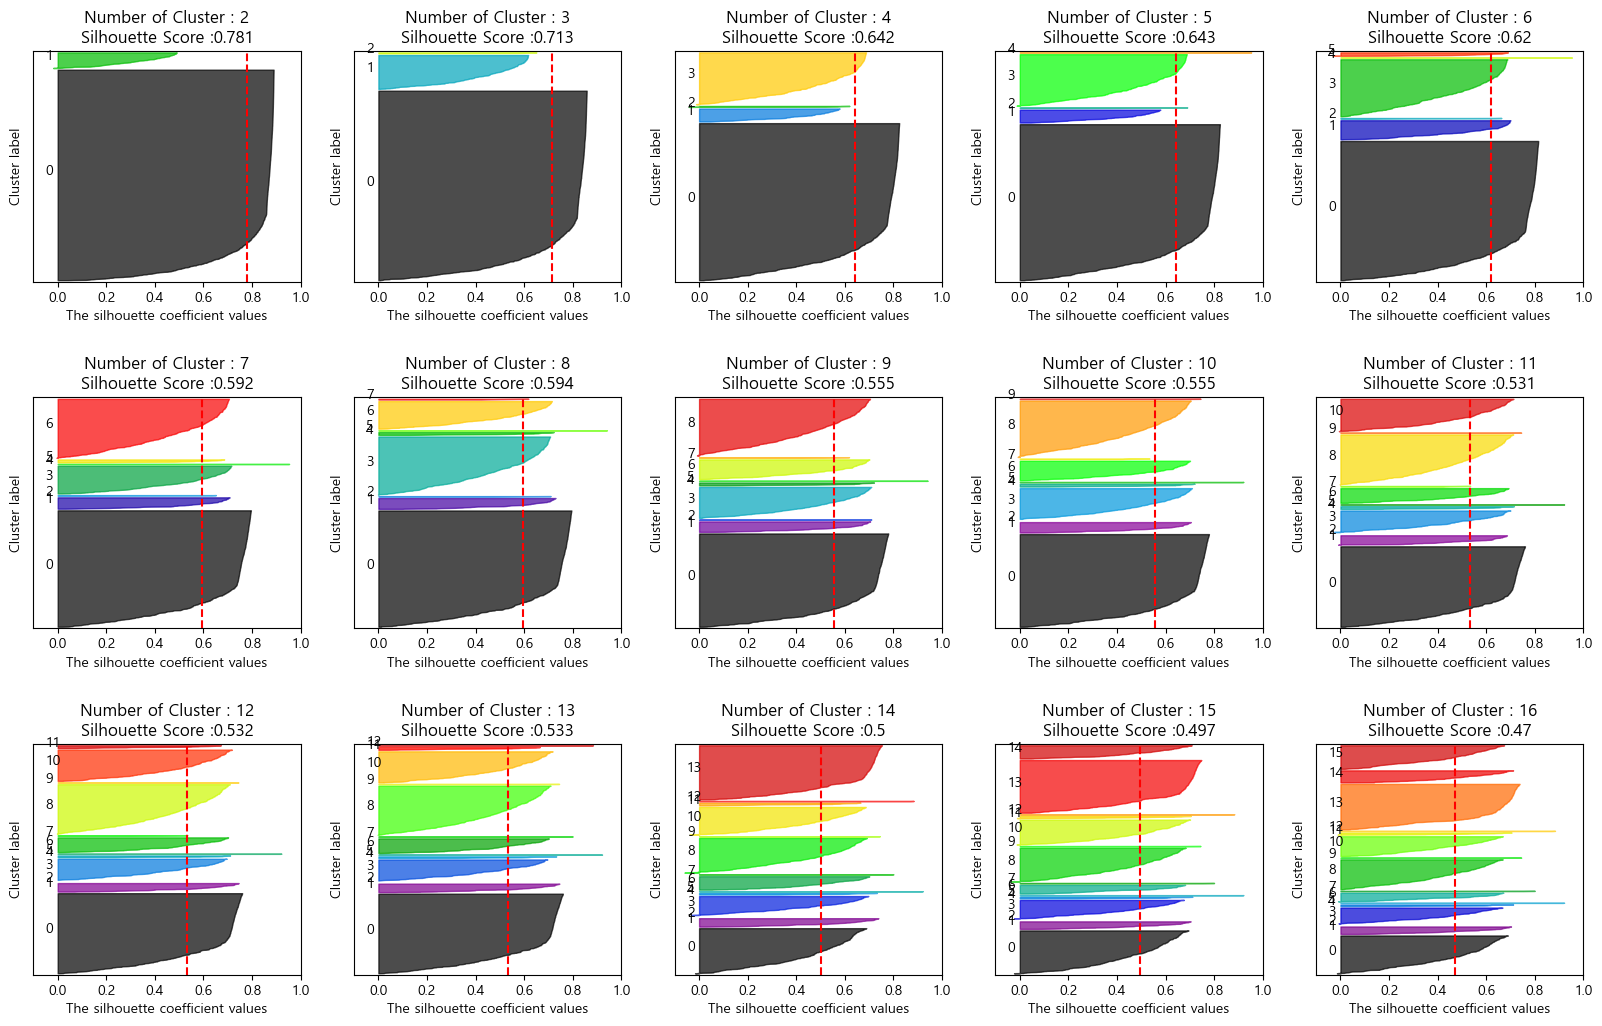

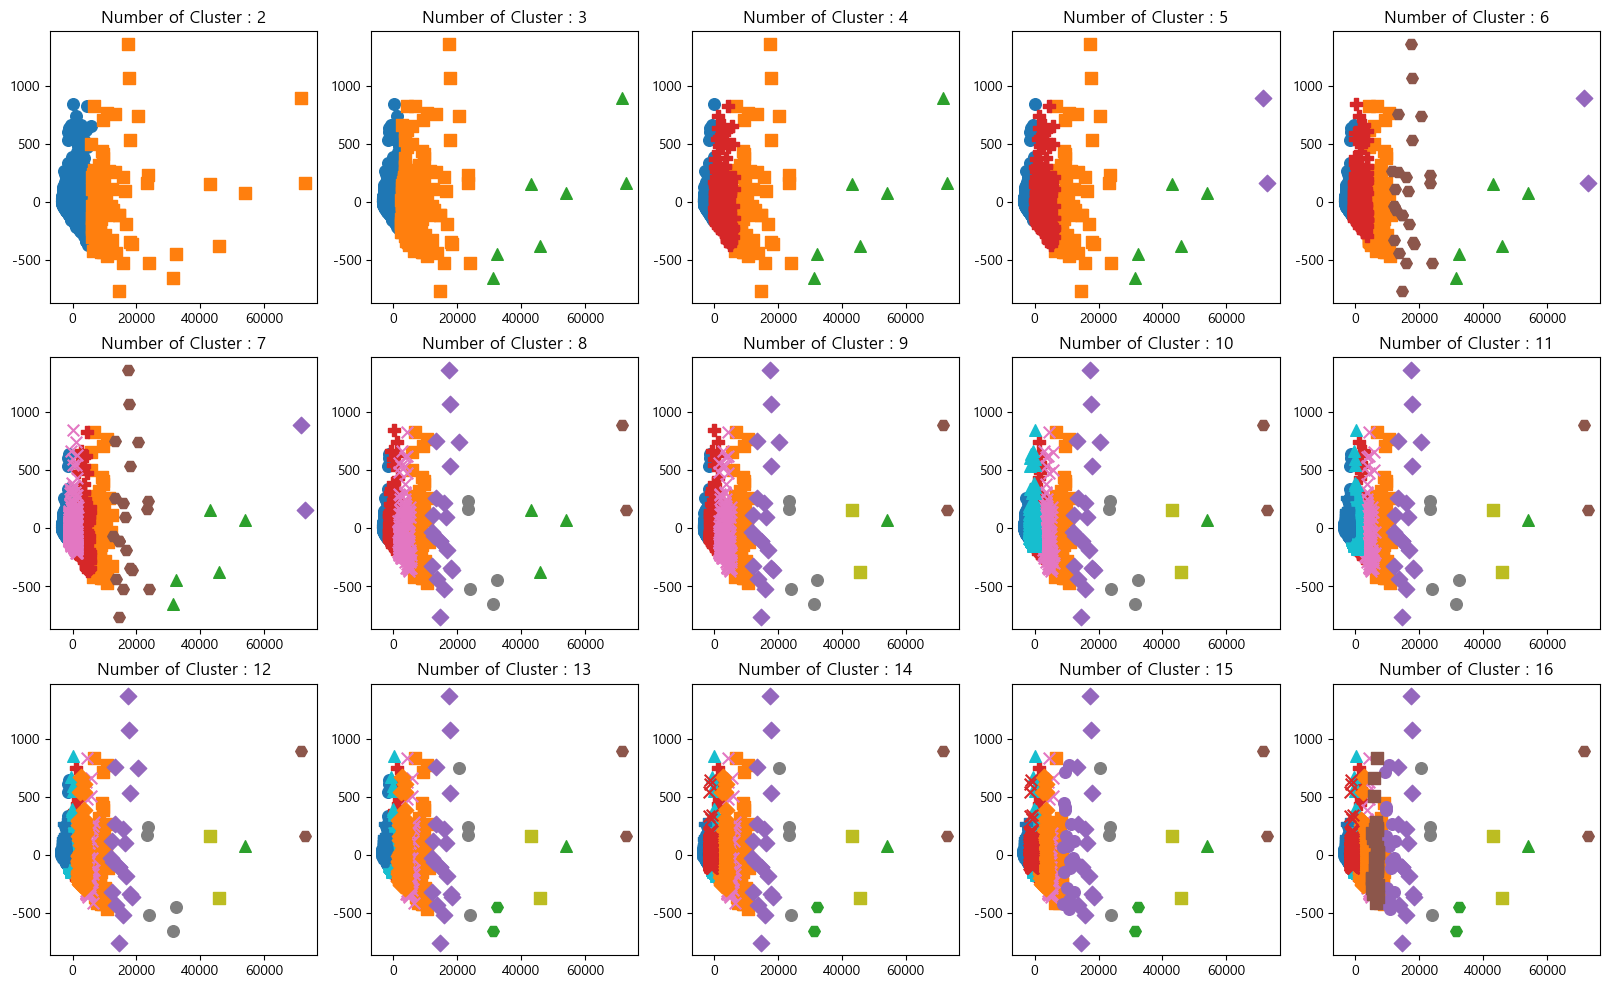

In [79]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')

visualize_silhouette(range(2, 17), features)
visualize_kmeans_plot_multi(range(2, 17),features)

- 2개 클러스터일 때 실루엣 스코어가 가장 높음(0.781), 3개 클러스터(0.713)
- 실루엣 스코어가 높지만 군집간 균등하게 나눠지진 않음

#### 스케일러1 - 스탠다드 스케일러

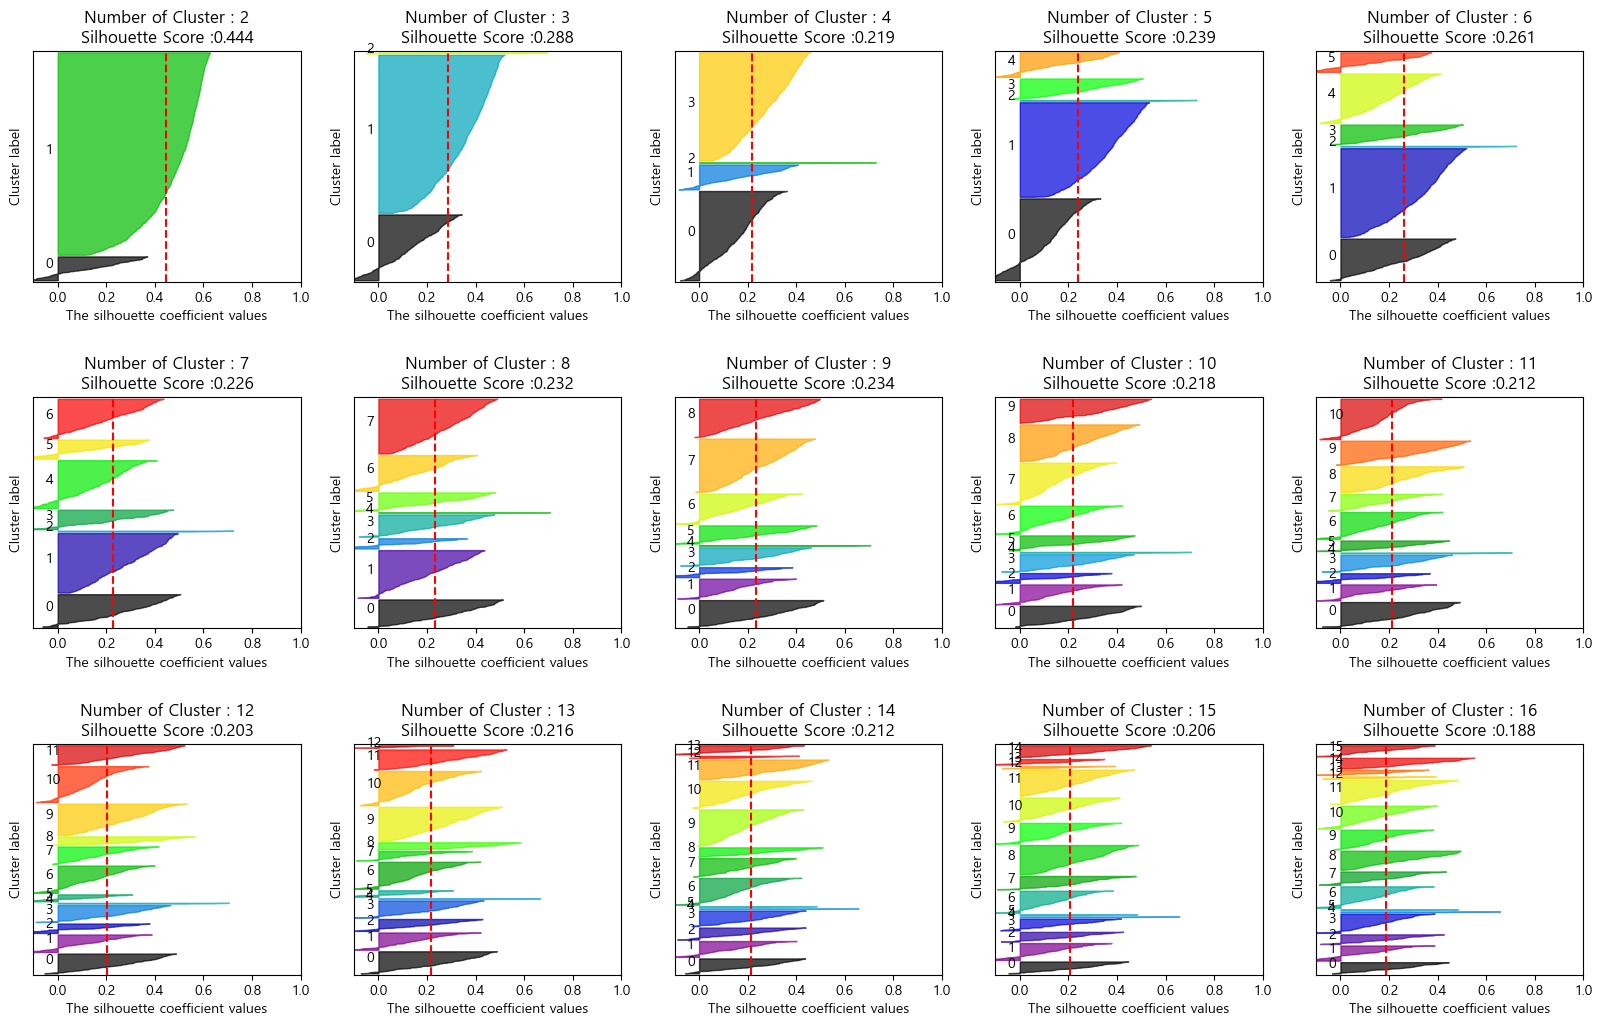

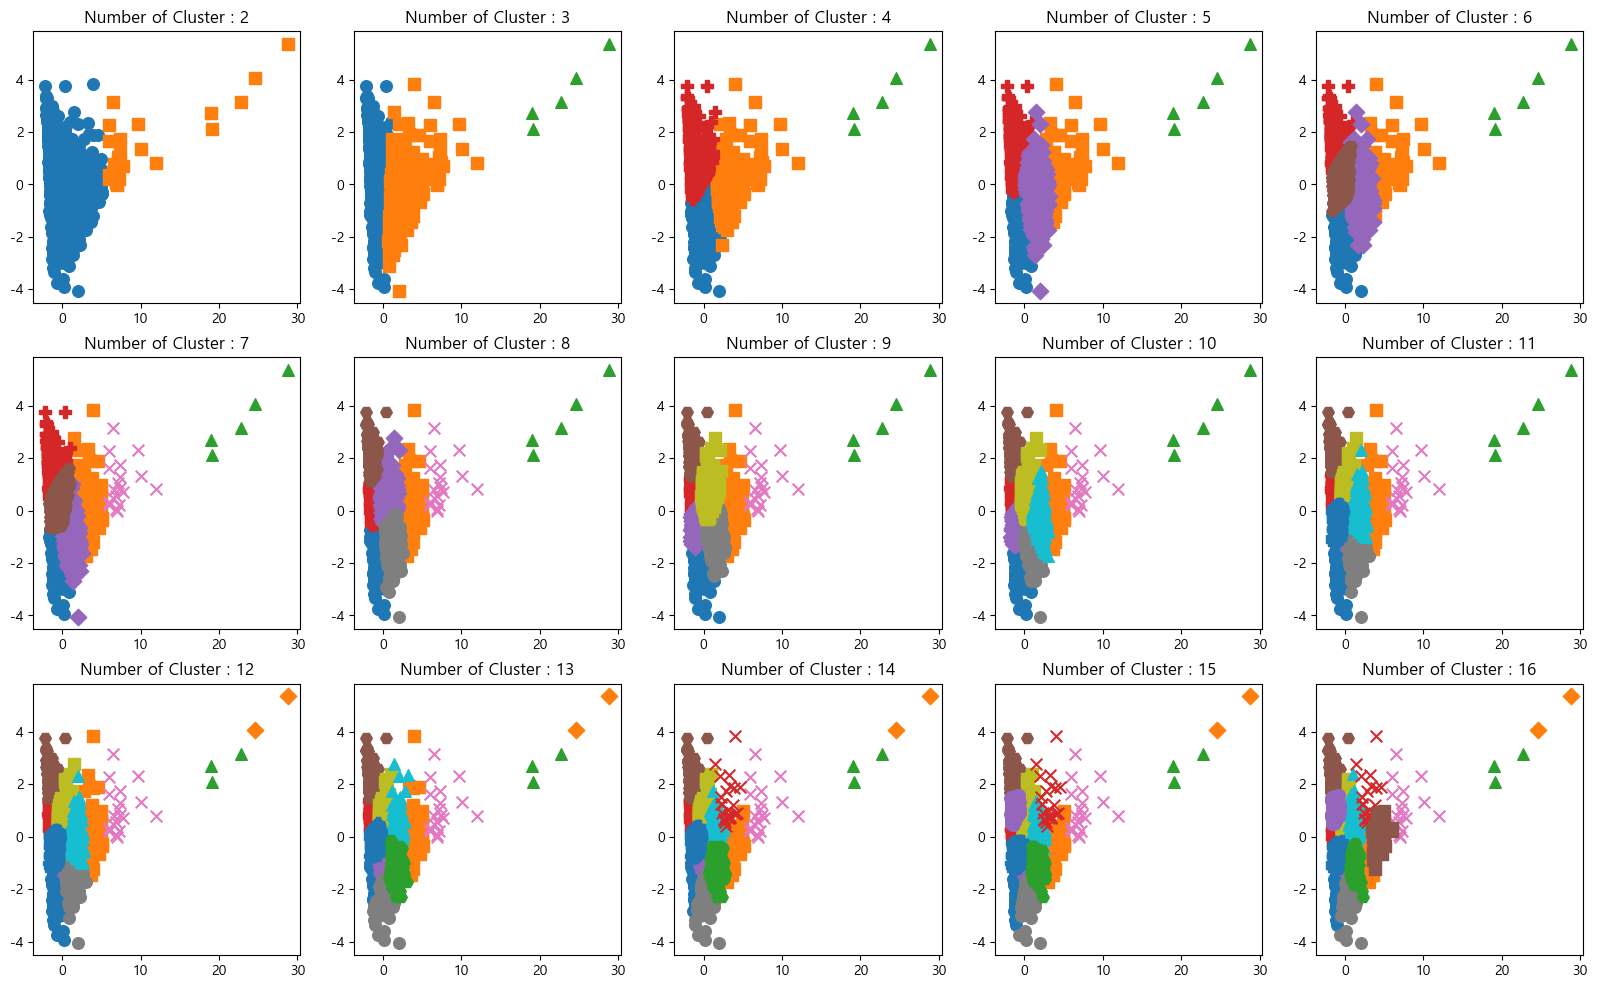

In [73]:
from sklearn.preprocessing import StandardScaler

features_ss = StandardScaler().fit_transform(features)

visualize_silhouette(range(2, 17), features_ss)
visualize_kmeans_plot_multi(range(2, 17),features_ss)

#### 스케일러2 - MinMaxScaler

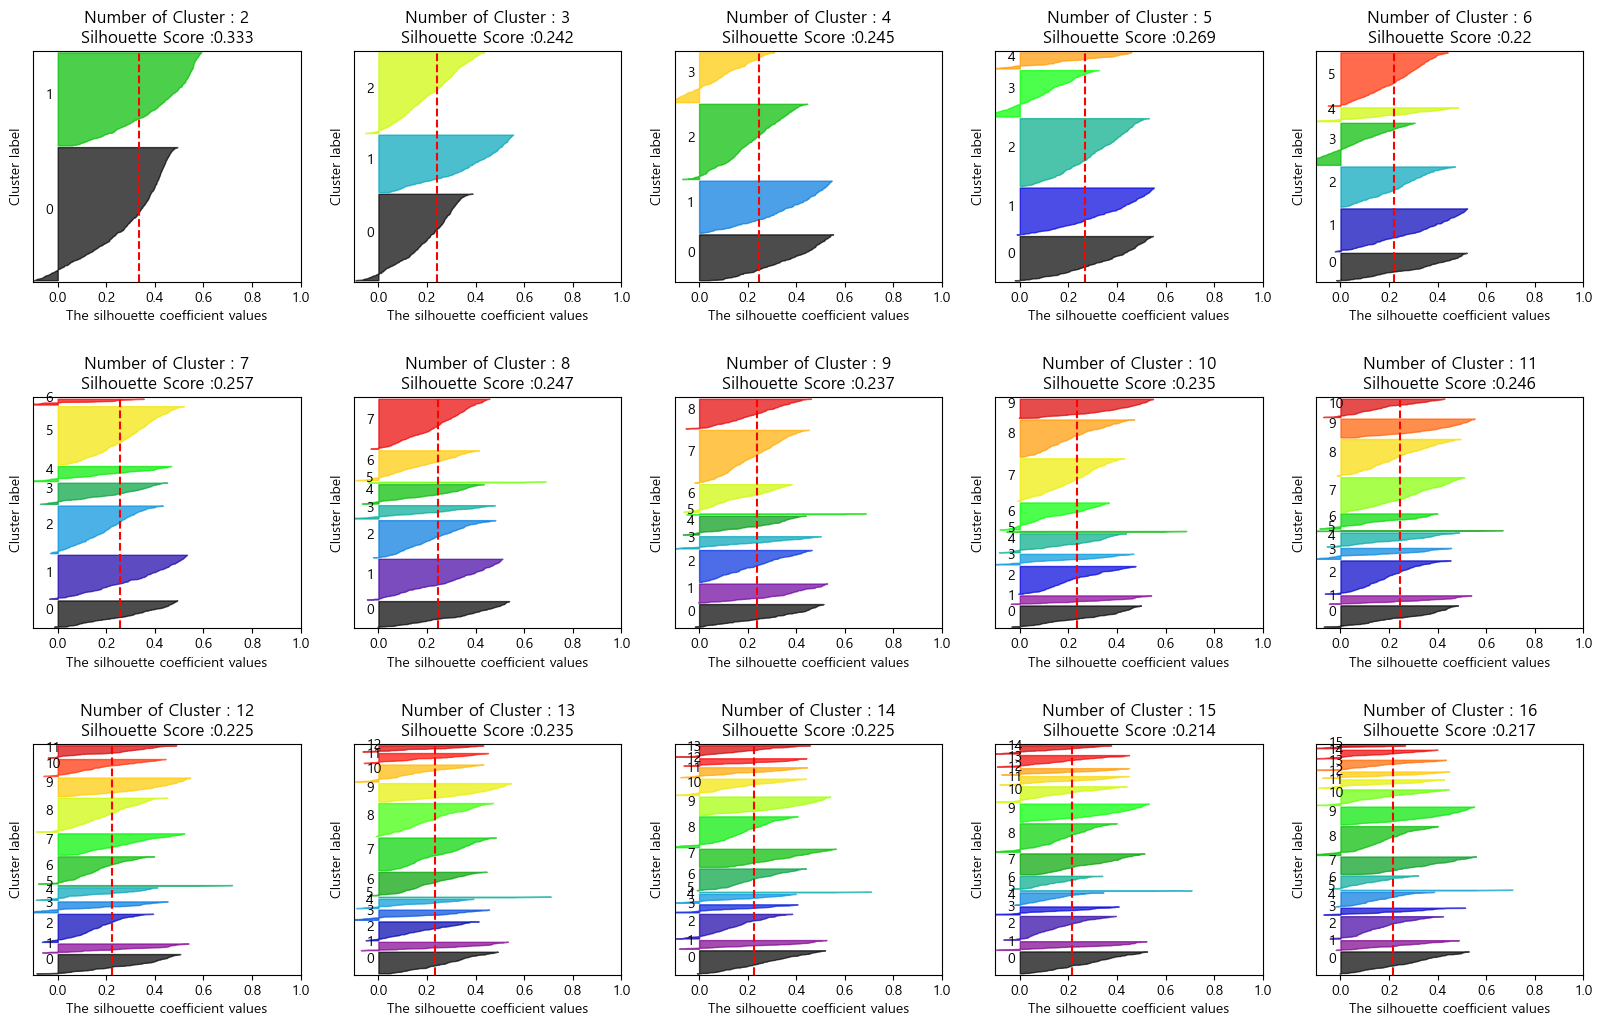

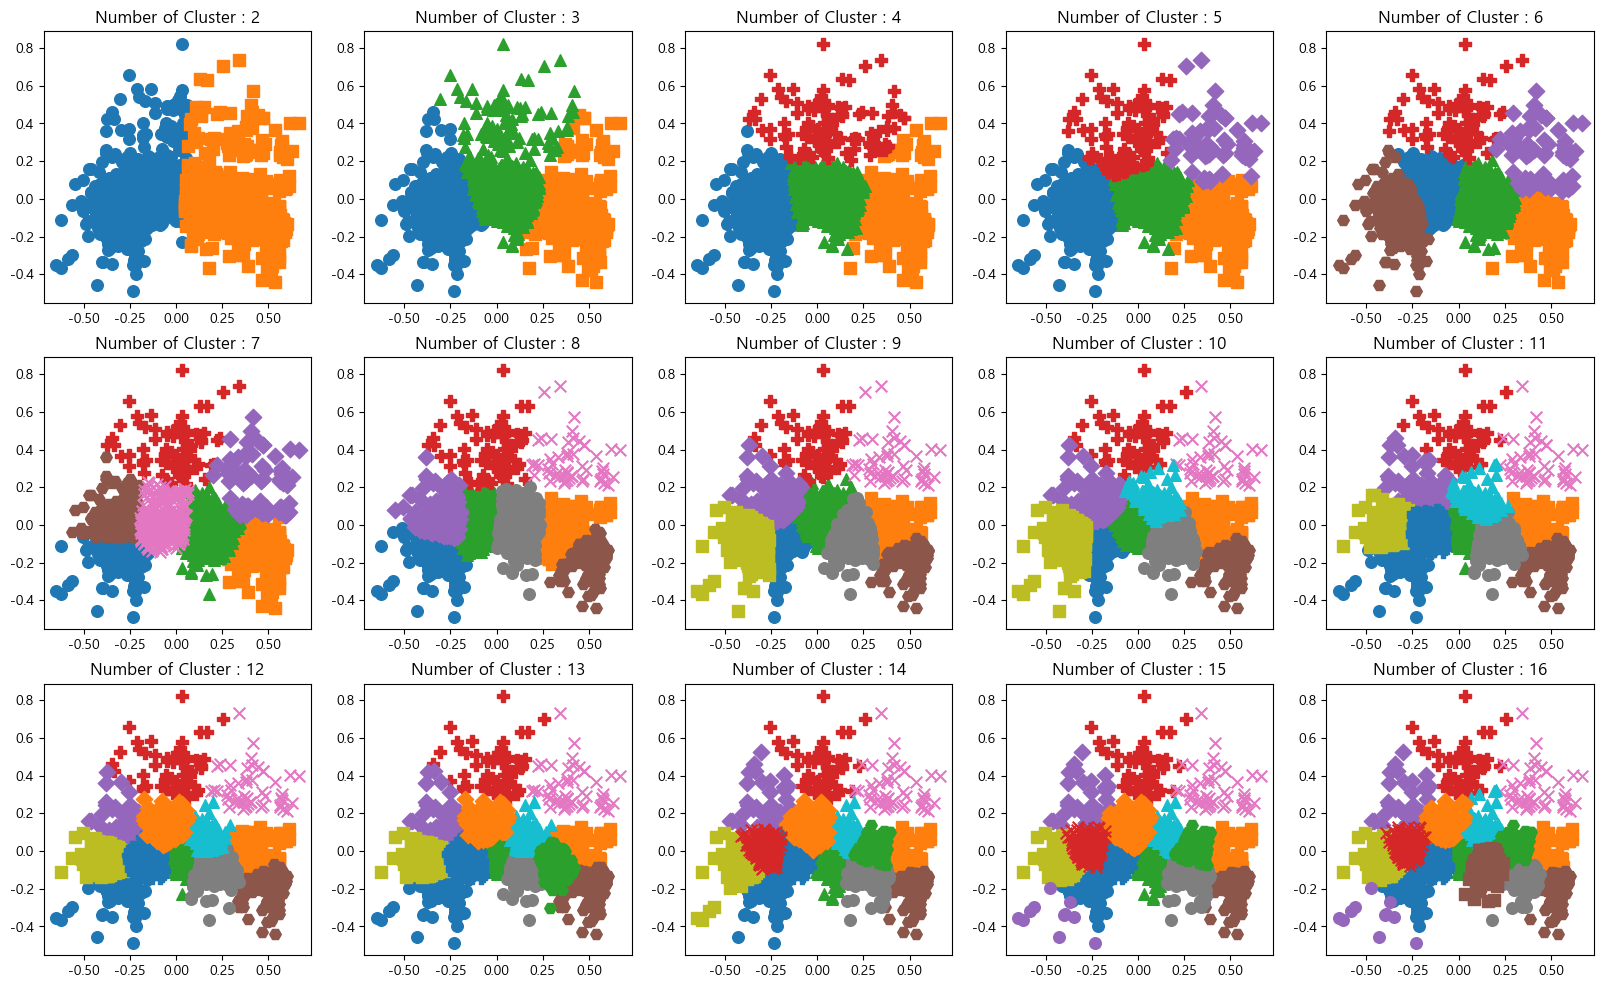

In [74]:
from sklearn.preprocessing import MinMaxScaler

features_ms = MinMaxScaler().fit_transform(features)

visualize_silhouette(range(2, 17), features_ms)
visualize_kmeans_plot_multi(range(2, 17),features_ms)

#### 스케일러3 - RobustScaler

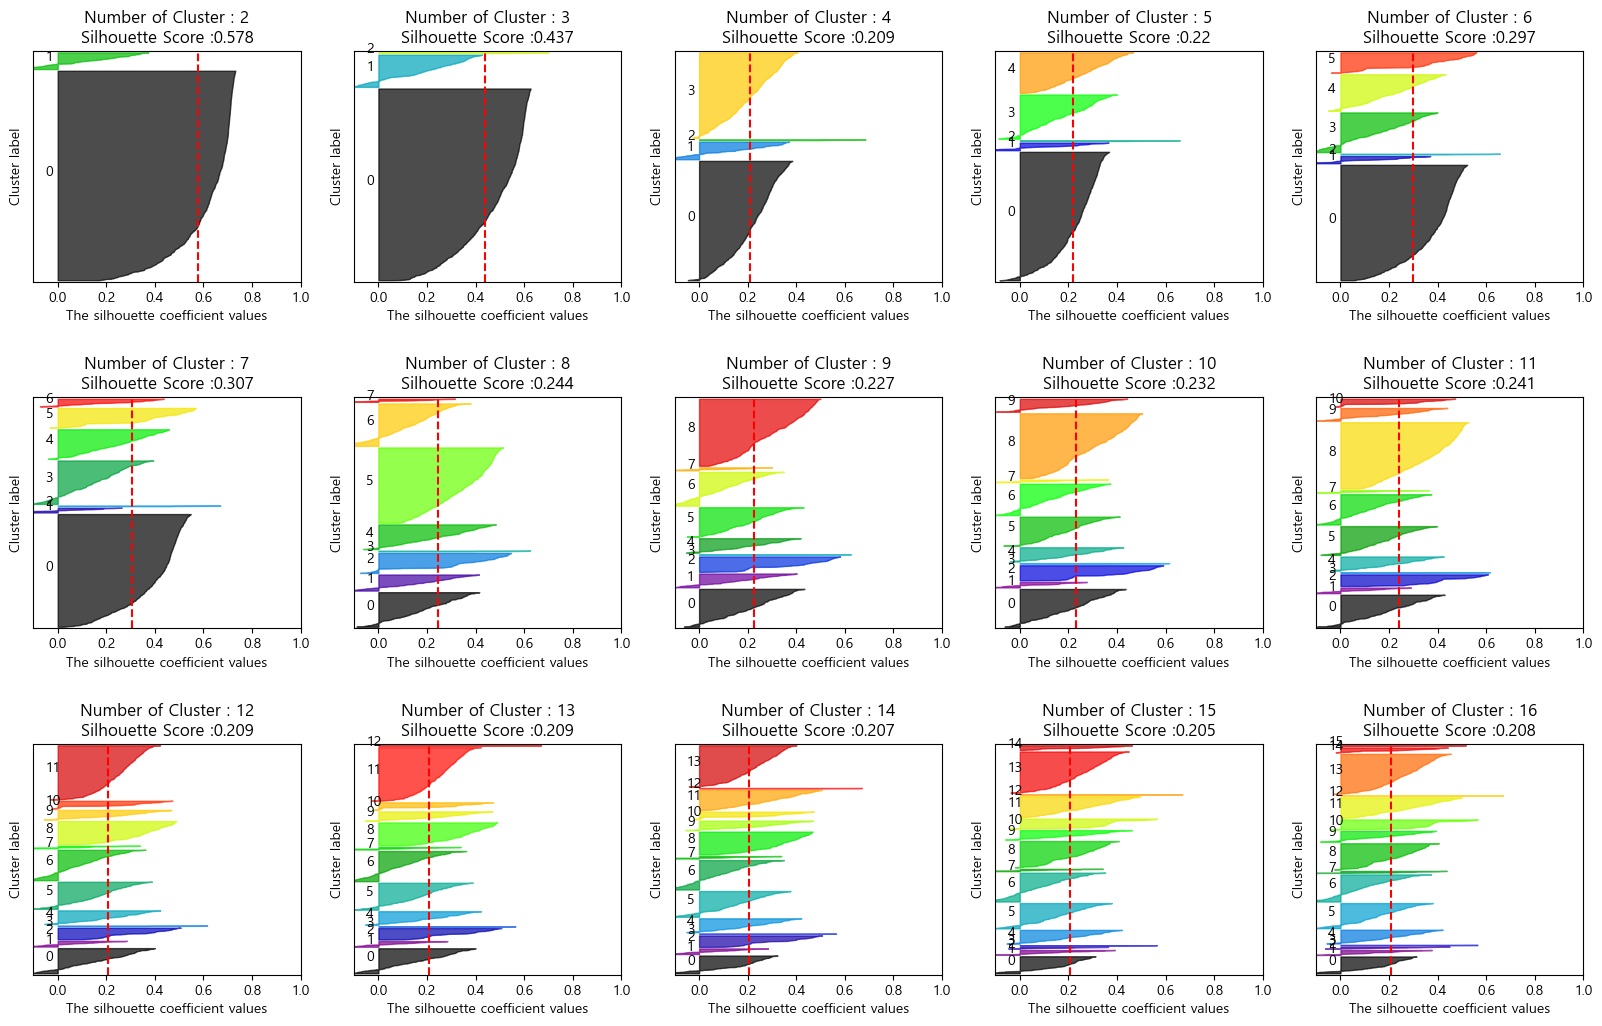

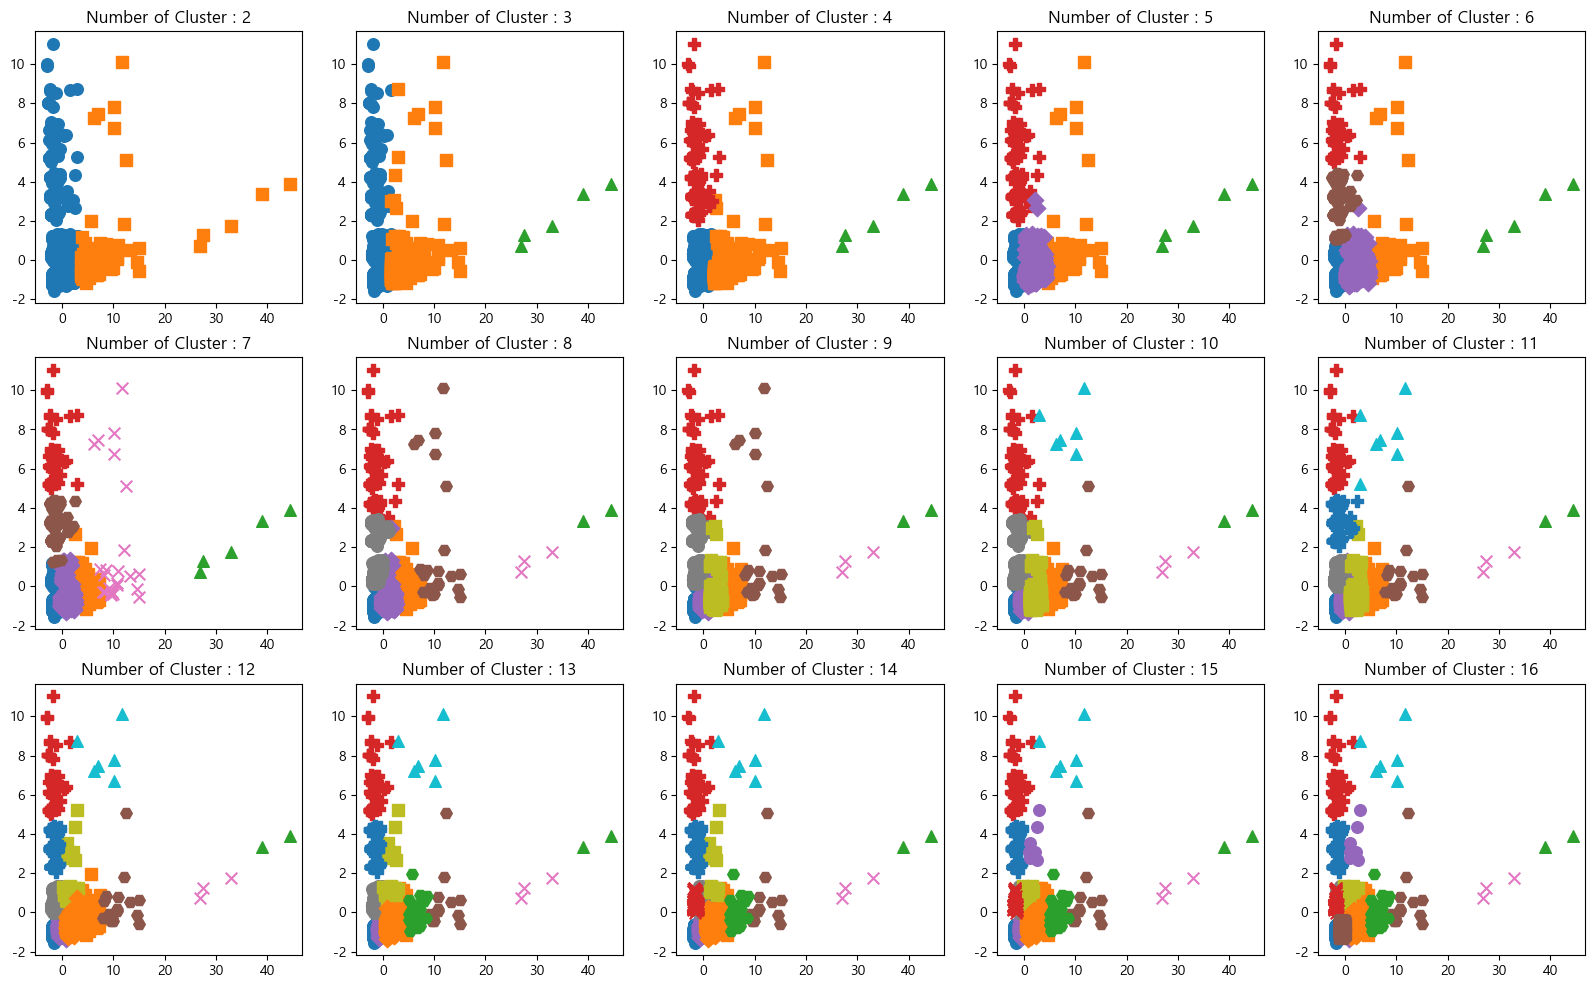

In [75]:
from sklearn.preprocessing import RobustScaler

features_rs = RobustScaler().fit_transform(features)

visualize_silhouette(range(2, 17), features_rs)
visualize_kmeans_plot_multi(range(2, 17),features_rs)

- 스케일러 적용시 전반적으로 실루엣 스코어 하락
    - 성능 : Robust > Standard > MinMax
- MinMaxScaler 적용시 실루엣 스코어는 저조하지만, 클러스터별로 분리가 잘 되어 있고 균등하게 나뉘어져 보임
- 스케일러를 적용하지 않았을 때 가장 실루엣 스코어가 좋게 나오지만, 이는 스케일이 큰 일부 변수(총지출액, 거래건수 등)의 영향일 수 있음
    - KMeans는 거리 기반으로 클러스터를 형성하기에 스케일에 민감함
    - RFM 분석에서 확인했듯, 일부 고객의 지출액과 거래건수가 많기에 이런 이상치가 분리도를 증가시켜 실루엣 스코어를 높일 수 있음

> 실루엣 스코어 해석 기준
- 0.71 - 1.0: 강한 구조가 있는 군집
- 0.51 - 0.7: 중간 정도의 구조를 가진 군집
- 0.26 - 0.5: 구조가 약하며 군집화가 의심스러운 경우
- < 0.25: 군집화에 실패했거나 군집 구조가 없는 데이터

## DBSCAN

실루엣 스코어: 0.6829494623001001
[-1  0]


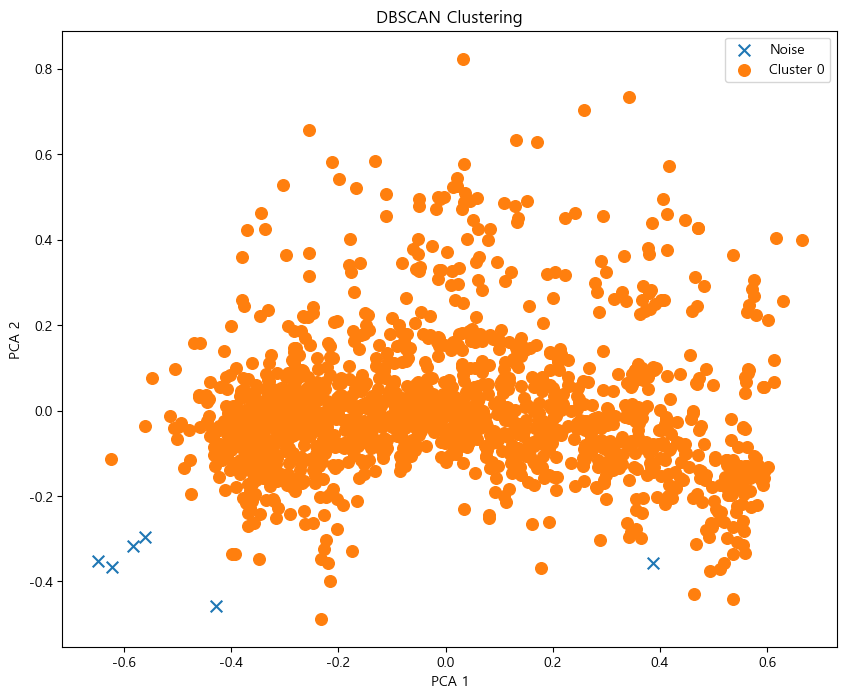

In [129]:
from sklearn.cluster import DBSCAN

def get_cluster_by_dbscan(input, eps, min_samples):
    X = input
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)
    
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    dataframe['cluster']=cluster_labels
    
    # 노이즈 포인트(-1 레이블)를 제외하고 스코어 계산
    if len(np.unique(cluster_labels)) > 1:  # 노이즈만 있는 경우를 제외
        sil_score = silhouette_score(X, cluster_labels)
        print("실루엣 스코어:", sil_score)
    else:
        print("유효한 클러스터가 없습니다.")

    unique_labels = np.unique(cluster_labels)
    print(unique_labels)
    
    fig, axs = plt.subplots(figsize=(10, 8))
    
    markers=['o', 's', '^', 'P', 'D', 'H', 'x']
    
    for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)         
            axs.scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        marker=markers[label], label=cluster_legend)

    plt.title('DBSCAN Clustering')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(loc='upper right')
    plt.show()
    
    
get_cluster_by_dbscan(features_ms, 0.5, 10)

실루엣 스코어: -0.11697936116399082
[-1  0  1  2]


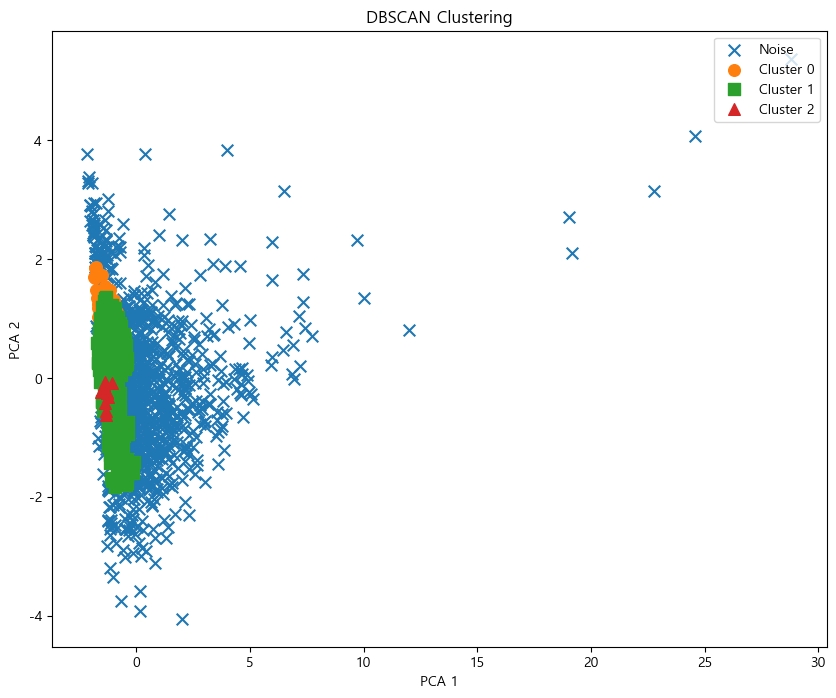

In [135]:
get_cluster_by_dbscan(features_ss, 0.5, 10)

실루엣 스코어: -0.11172601049829912
[-1  0  1]


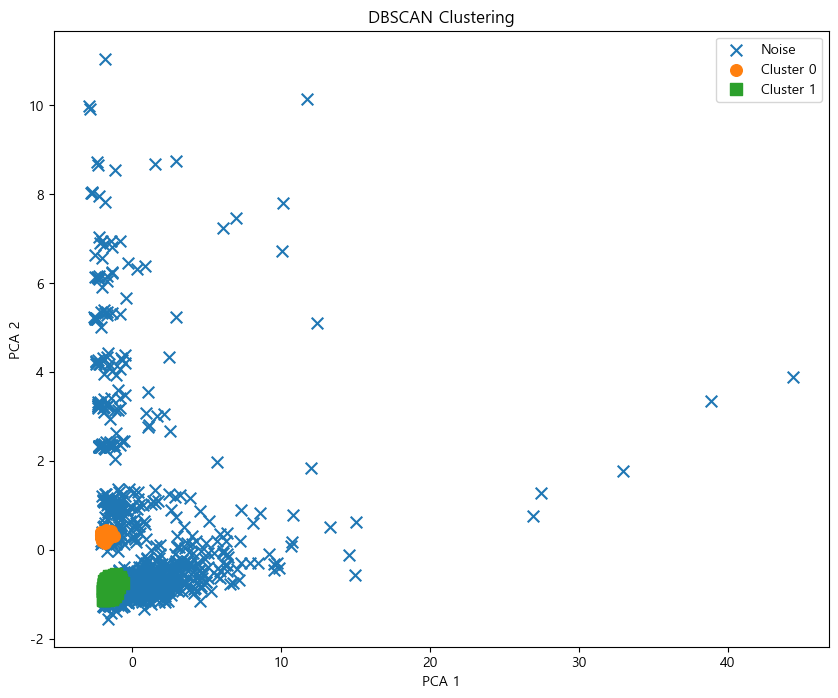

In [136]:
get_cluster_by_dbscan(features_rs, 0.5, 10)

유효한 클러스터가 없습니다.
[-1]


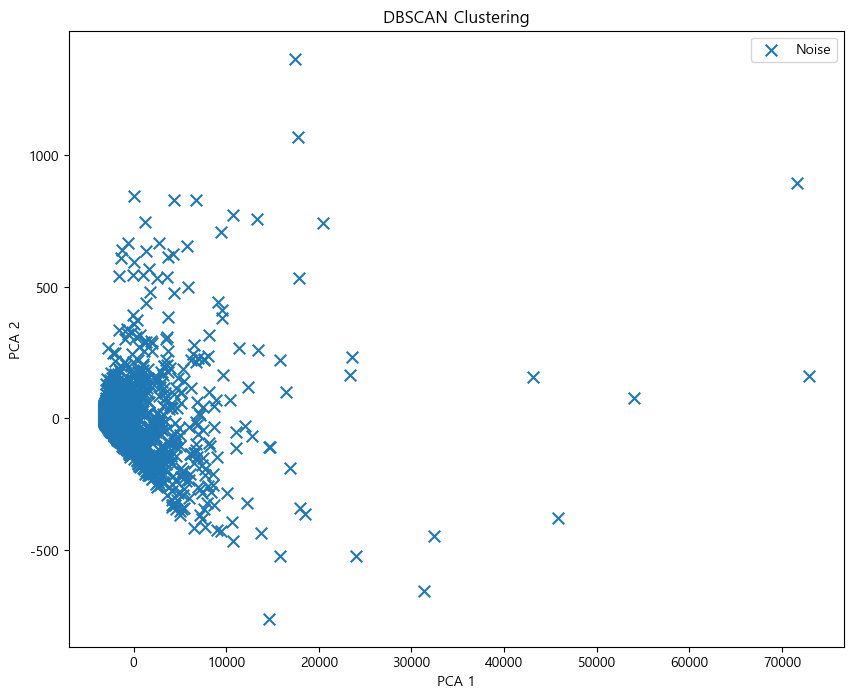

In [137]:
get_cluster_by_dbscan(features, 0.5, 10)

### 최적의 eps, min_samples 찾기

#### MinMaxScaler

In [177]:
eps_values = np.arange(0.1, 0.4, 0.01) 
min_samples_values = range(3, 15) 

def grid_search_parameter(input, eps_values, min_samples_values):
    best_score = -1
    best_eps = None
    best_min_samples = None

    # 그리드 탐색
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(input)
            if len(np.unique(labels)) > 2: # 노이즈를 제외하고 최소 2개의 클러스터로 분리하기 위해
                score = silhouette_score(input, labels)
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    print(f"Best Score: {best_score}, EPS: {best_eps}, min_samples: {best_min_samples}")
    
grid_search_parameter(features_ms, eps_values, min_samples_values)

Best Score: 0.5966913824059372, EPS: 0.3799999999999999, min_samples: 3


실루엣 스코어: 0.5966913824059372
[-1  0  1]


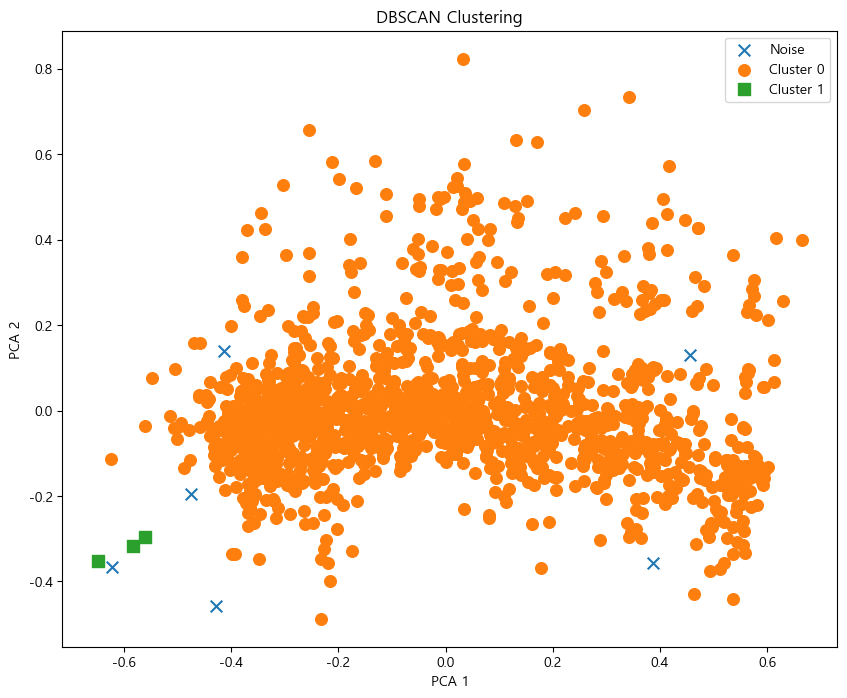

In [127]:
get_cluster_by_dbscan(features_ms, 0.38, 3)

- 2개의 클러스터로 나눠지긴 했지만, 노이즈 6개 제외 3명을 제외한 나머지 고객이 하나의 클러스터로 묶이는데 실질적인 의미가 없음
- 그래프 상으로 나타나는 데이터 포인트의 밀집도도 높지 않음

In [178]:
eps_values = np.arange(0.1, 0.8, 0.01) 
min_samples_values = range(10, 20) 
grid_search_parameter(features_ms, eps_values, min_samples_values)

Best Score: 0.15481122733730654, EPS: 0.14999999999999997, min_samples: 12


실루엣 스코어: 0.15481122733730654
[-1  0  1]


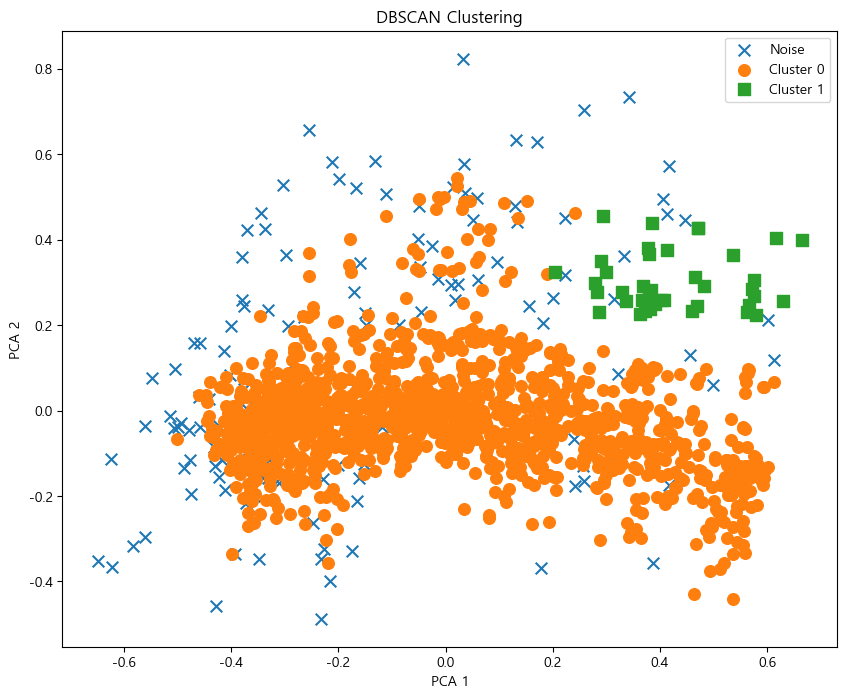

In [179]:
get_cluster_by_dbscan(features_ms, 0.15, 12)

- 하나의 클러스터에 속해야 하는 최소 고객 숫자를 증가시켰음
- 노이즈로 분류되는 비율이 많고, 실루엣 스코어도 낮게 나옴

#### 스탠다드 스케일러

In [180]:
eps_values = np.arange(0.1, 0.8, 0.01) 
min_samples_values = range(10, 20) 
grid_search_parameter(features_ss, eps_values, min_samples_values)

Best Score: 0.15252928307696573, EPS: 0.7899999999999996, min_samples: 11


실루엣 스코어: 0.15252928307696573
[-1  0  1]


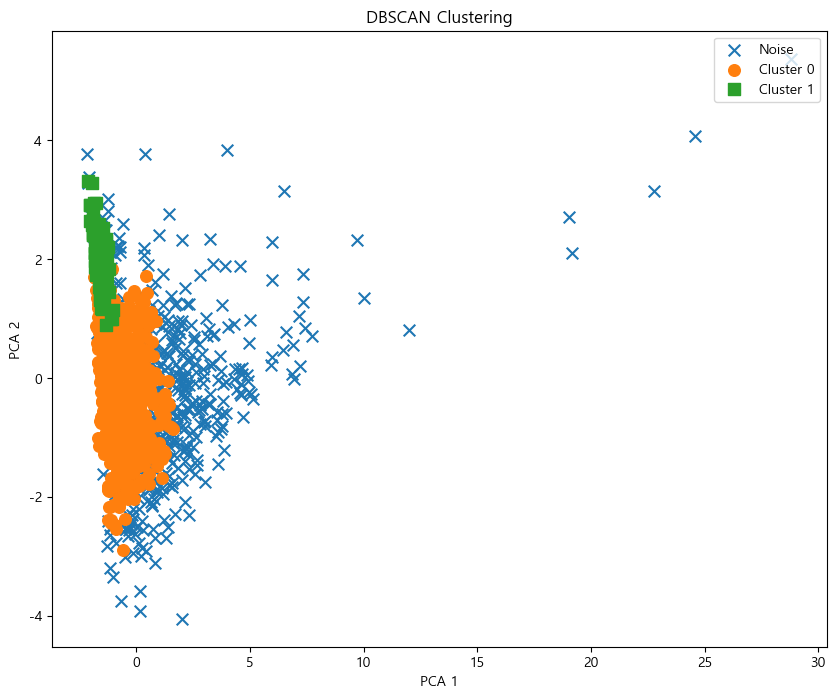

In [181]:
get_cluster_by_dbscan(features_ss, 0.79, 11)

- 실루엣 스코어도 저조하고, 그래프상으로 확인할 수 있듯 데이터간 분리도도 낮음

#### 로버스트 스케일러

In [182]:
eps_values = np.arange(0.1, 0.8, 0.01) 
min_samples_values = range(10, 20) 
grid_search_parameter(features_rs, eps_values, min_samples_values)

Best Score: -0.019828519655029096, EPS: 0.7899999999999996, min_samples: 12


#### 스케일러 미적용

In [183]:
grid_search_parameter(features, eps_values, min_samples_values)

Best Score: -1, EPS: None, min_samples: None


> DBSCAN에서는 유의미한 결과를 얻지 못함

- KMeans와 DBSCAN에서 모두 좋은 결과가 나오지 않는 건 이상치가 너무 많아서일 가능성
    1. GMM - dbscan과 마찬가지로 이상치 영향을 적게 받음
    2. 이상치 식별 후, 이를 제외한 데이터로 클러스터링 알고리즘 적용
    3. 이상치 데이터를 제거하는 대신 cap을 씌우는 방향으로

## 이상치 식별

In [152]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

outliers = iso_forest.fit_predict(features)

# 이상치는 -1, 정상치는 1
outliers_mask = outliers == -1

normal_data = df_input[~outliers_mask].drop('Cluster', axis=1)
outlier_data = df_input[outliers_mask].drop('Cluster', axis=1)

In [153]:
outlier_data

CustomerID  구매건수    평균구매간격  구매발생일수  Recency  총구매수량  구입상품_평균가격      총지출액  \
1     USER_0001    31  111.5000       3       60    342  62.436000  13834.90   
26    USER_0026    55   45.5000       3      266   1494  41.015102  13829.98   
33    USER_0033    70   33.2000      11       16    279  64.093359  13907.84   
34    USER_0034    67  146.0000       3       63    508  57.482778  11417.33   
39    USER_0039    13   37.6667       4      152    757  37.288696  10068.55   
...         ...   ...       ...     ...      ...    ...        ...       ...   
1395  USER_1395    31    0.0000       1      360   1202  39.536235   7527.65   
1397  USER_1397    35   86.0000       4       20   1397  37.013596  12532.34   
1411  USER_1411    95   65.6000       6       19    716  58.390920  14193.67   
1432  USER_1432    77   16.0000       6      169    374  41.828129  10616.44   
1433  USER_1433   120   53.2500       5      107   1230  45.768560  18954.30   

      구매제품_종류  최대지출_카테고리_인코딩  
1          42              2  
26         97              1  
33         73              1  
34         79              1  
39         39             10  
...       ...            ...  
1395       62              1  
1397       75              8  
1411       86              1  
1432      110              1  
1433      136              1  

[125 rows x 10 columns]

In [154]:
normal_data

CustomerID  구매건수  평균구매간격  구매발생일수  Recency  총구매수량   구입상품_평균가격     총지출액  \
0     USER_0000     1     0.0       1      108      3   12.745000    30.99   
2     USER_0002     8   119.0       2       74    209   14.631304  1442.12   
3     USER_0003    11     0.0       1       18     21   77.200000  1360.07   
4     USER_0004    13     0.0       1      108     56   34.578611  1442.47   
5     USER_0005     3     0.0       1      131     86   14.713125   601.81   
...         ...   ...     ...     ...      ...    ...         ...      ...   
1463  USER_1463     3     0.0       1      271     46   12.104286   544.34   
1464  USER_1464    19    52.5       3       88    141   27.872250  2363.05   
1465  USER_1465     2    76.0       2      195     10   11.167500   101.56   
1466  USER_1466     1     0.0       1       70      2  149.000000   298.00   
1467  USER_1467    53    73.0       2       83    155   55.470588  6362.77   

      구매제품_종류  최대지출_카테고리_인코딩  
0           2              2  
2          21              1  
3          11              1  
4          33              1  
5          16              2  
...       ...            ...  
1463        7              8  
1464       35              1  
1465        8              2  
1466        1              1  
1467       69              1  

[1343 rows x 10 columns]

In [155]:
outlier_data.describe()

구매건수     평균구매간격      구매발생일수     Recency        총구매수량   구입상품_평균가격  \
count  125.000000  125.00000  125.000000  125.000000   125.000000  125.000000   
mean    62.928000   64.41684    5.320000  100.696000   758.928000   56.491722   
std     58.751139   74.11733    5.401015  105.962883   744.619097   31.122181   
min      1.000000    0.00000    1.000000    1.000000     1.000000    1.240000   
25%     29.000000   16.00000    2.000000   20.000000   332.000000   40.827679   
50%     52.000000   40.60000    4.000000   56.000000   606.000000   49.949316   
75%     76.000000   79.00000    7.000000  150.000000   939.000000   65.947342   
max    328.000000  351.00000   34.000000  365.000000  4869.000000  203.000000   

               총지출액     구매제품_종류  최대지출_카테고리_인코딩  
count    125.000000  125.000000     125.000000  
mean   12759.414960   74.576000       2.600000  
std    12152.072189   54.994173       2.839809  
min        1.240000    1.000000       1.000000  
25%     6817.960000   37.000000       1.000000  
50%    10635.220000   69.000000       1.000000  
75%    14233.350000   98.000000       3.000000  
max    75937.550000  308.000000      13.000000

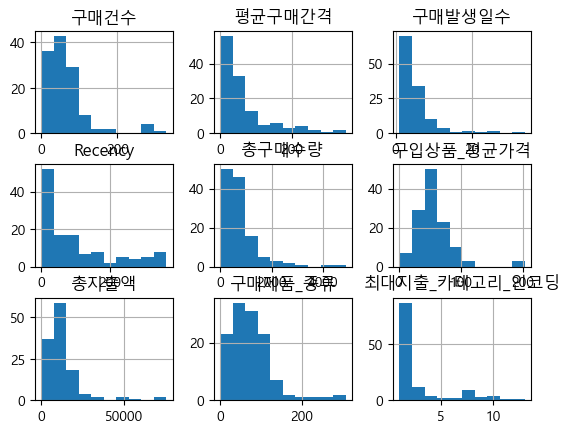

In [156]:
outlier_data.hist();

In [164]:
normal_data.describe()

구매건수       평균구매간격       구매발생일수      Recency        총구매수량  \
count  1343.000000  1343.000000  1343.000000  1343.000000  1343.000000   
mean     13.972450    29.488717     1.893522   149.443038   106.618019   
std      12.600238    50.770982     1.328854   100.593534   138.460094   
min       1.000000     0.000000     1.000000     1.000000     1.000000   
25%       5.000000     0.000000     1.000000    63.000000    17.000000   
50%      10.000000     0.000000     1.000000   137.000000    52.000000   
75%      20.000000    48.000000     2.000000   222.000000   141.000000   
max      73.000000   332.000000     9.000000   364.000000   976.000000   

         구입상품_평균가격          총지출액      구매제품_종류  최대지출_카테고리_인코딩  
count  1343.000000   1343.000000  1343.000000    1343.000000  
mean     51.852003   2290.762442    21.104244       1.676098  
std      30.310728   2250.958235    17.608116       1.565296  
min       1.000000      1.000000     1.000000       1.000000  
25%      31.163652    599.130000     8.000000       1.000000  
50%      47.538333   1565.690000    16.000000       1.000000  
75%      67.264167   3269.490000    30.000000       2.000000  
max     204.000000  11173.140000   108.000000      12.000000

- 이상치로 분류된 데이터와 정상 데이터를 비교하면, 이상치 데이터의 평균 구매건수와 평균 총지출액이 더 크게 나타남
    - 단발성 대량 구매를 한 고객이 이상 데이터로 분리되었음

In [167]:
outlier_data[outlier_data['총지출액']<2000]

CustomerID  구매건수    평균구매간격  구매발생일수  Recency  총구매수량   구입상품_평균가격     총지출액  \
345   USER_0345     1    0.0000       1      365      1    1.240000     1.24   
516   USER_0516     2  167.0000       2       90      3    5.795000    20.79   
603   USER_0603     9   83.3333       4       29    136  108.942143  1727.30   
822   USER_0822     5  103.0000       2       61      8  203.000000  1372.00   
847   USER_0847     1    0.0000       1       76      1  199.000000   199.00   
940   USER_0940     3  245.0000       2       77     70   21.616250   497.31   
972   USER_0972     1    0.0000       1       16      6  202.845000   605.49   
1030  USER_1030     5    0.0000       1      361    708   29.816429  1890.33   
1097  USER_1097     5   56.0000       2      224    297   44.623000  1165.85   
1136  USER_1136    18  126.0000       2       76    153   30.223438  1556.63   
1263  USER_1263     7  178.0000       2      108     21   18.399231   262.71   
1320  USER_1320     4  100.0000       2      153      9   96.370000   969.96   
1332  USER_1332     2   77.0000       2      138    177    9.285000   673.38   
1347  USER_1347     3   33.0000       2      331    178   14.866000   797.12   

      구매제품_종류  최대지출_카테고리_인코딩  
345         1              7  
516         2              7  
603        11             11  
822         3              3  
847         1              3  
940         8             10  
972         2              3  
1030       12              4  
1097        9              7  
1136       24              9  
1263       12              9  
1320        8              9  
1332       12             13  
1347       15              7

- 이상 데이터에는 총지출액이 큰 다수의 고객이 대다수.
    - 이상 데이터 일부는 총지출액은 낮은 고객도 포함

### 정상 데이터 KMeans 적용

In [168]:
norm_features = normal_data.drop('CustomerID', axis=1).copy()

norm_ss = StandardScaler().fit_transform(norm_features)
norm_ms = MinMaxScaler().fit_transform(norm_features)
norm_rs = RobustScaler().fit_transform(norm_features)

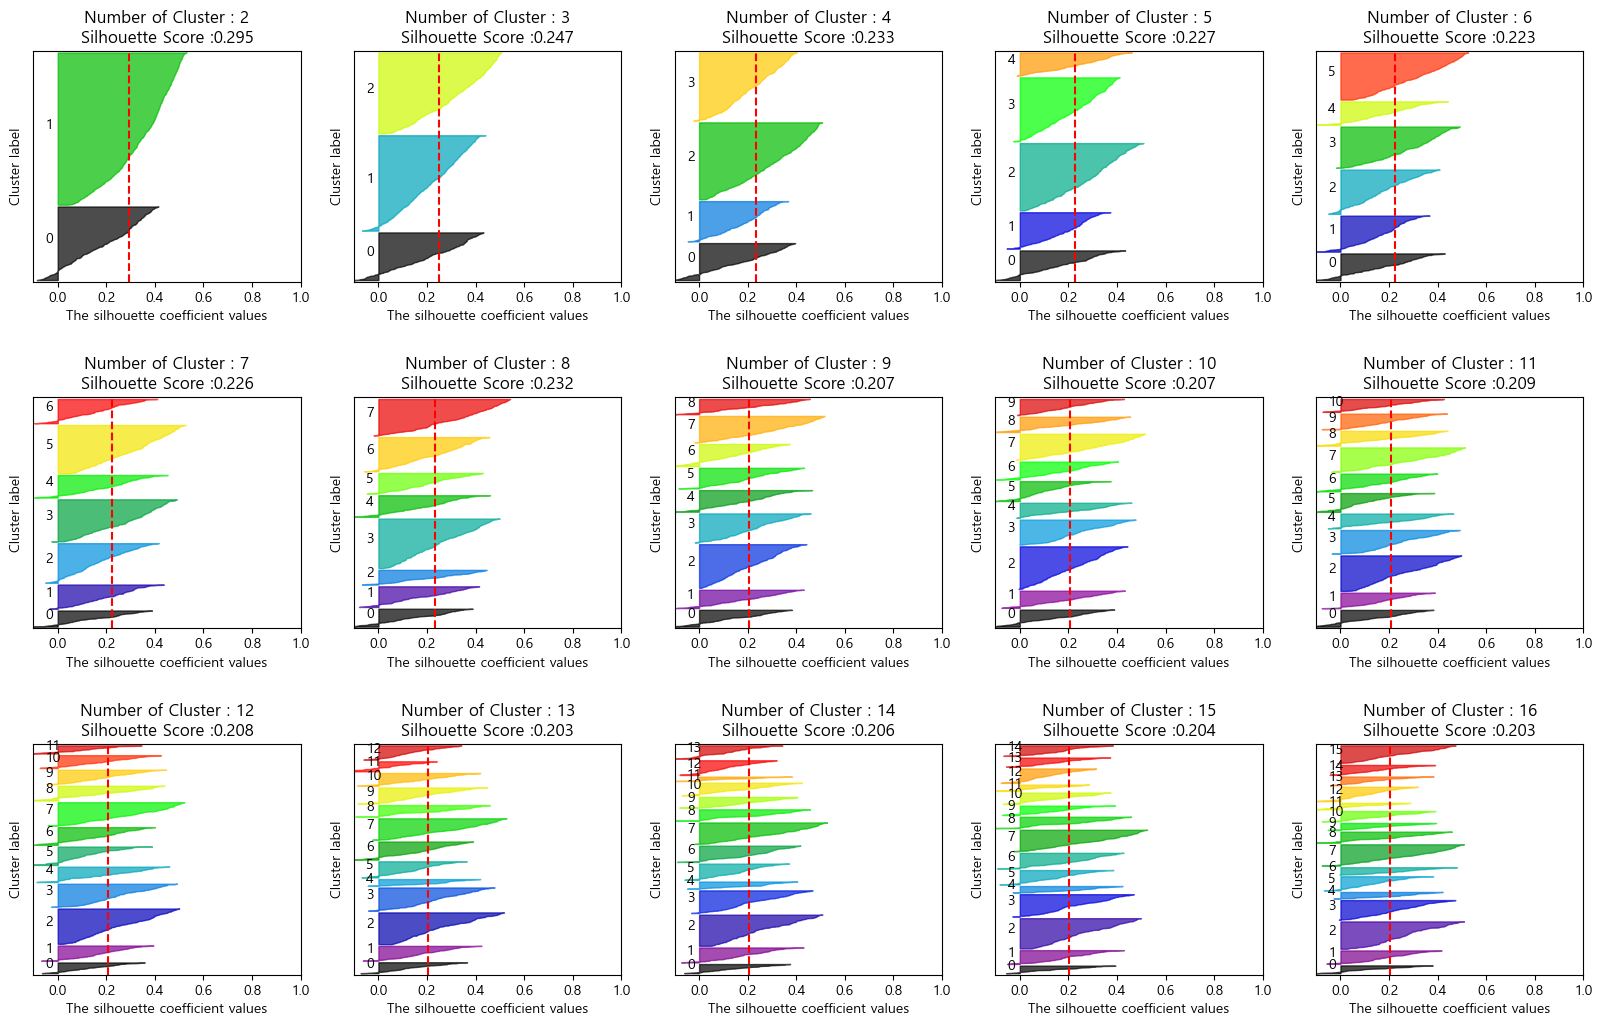

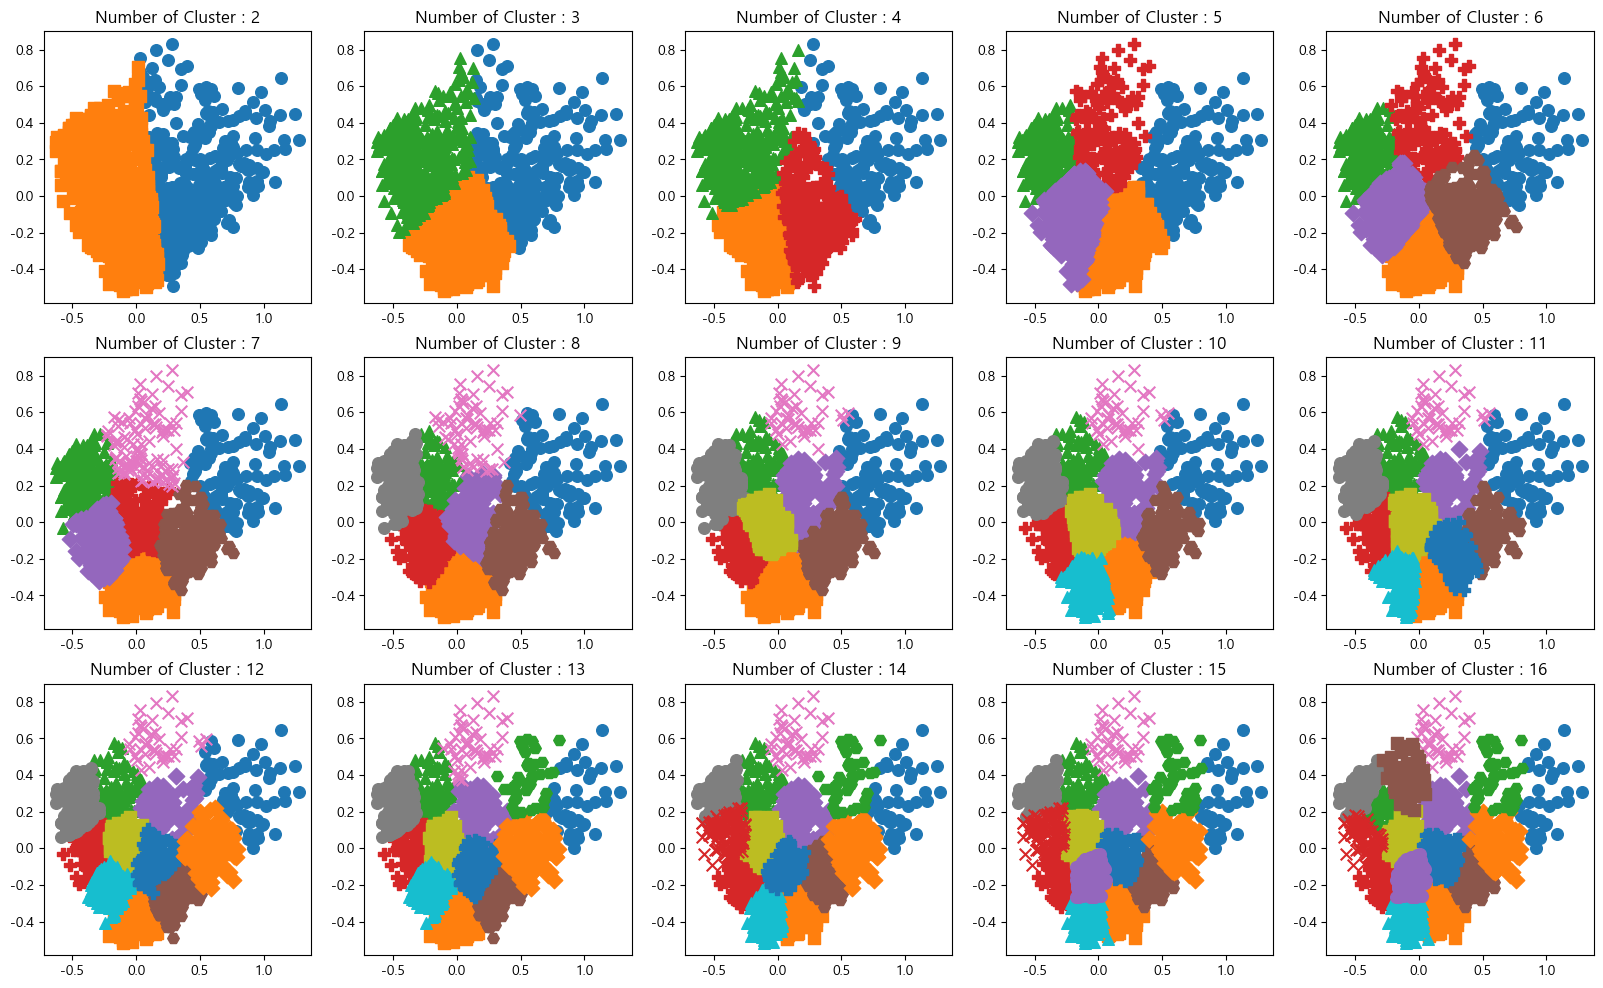

In [169]:
visualize_silhouette(range(2, 17), norm_ms)
visualize_kmeans_plot_multi(range(2, 17),norm_ms)

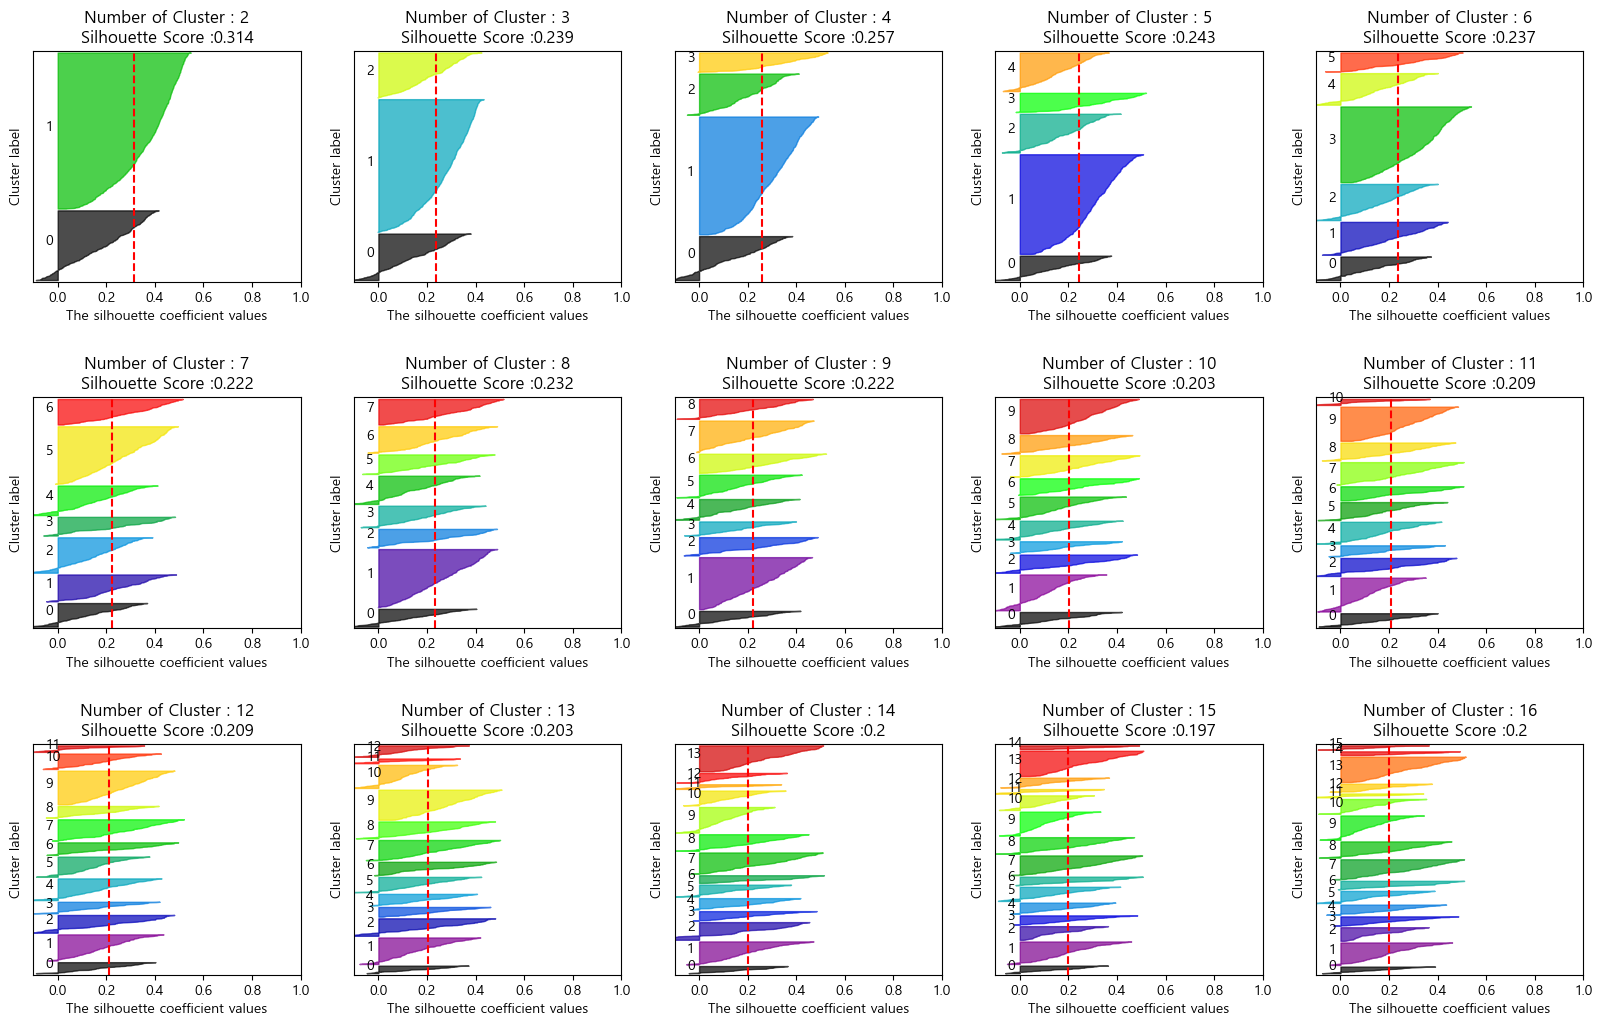

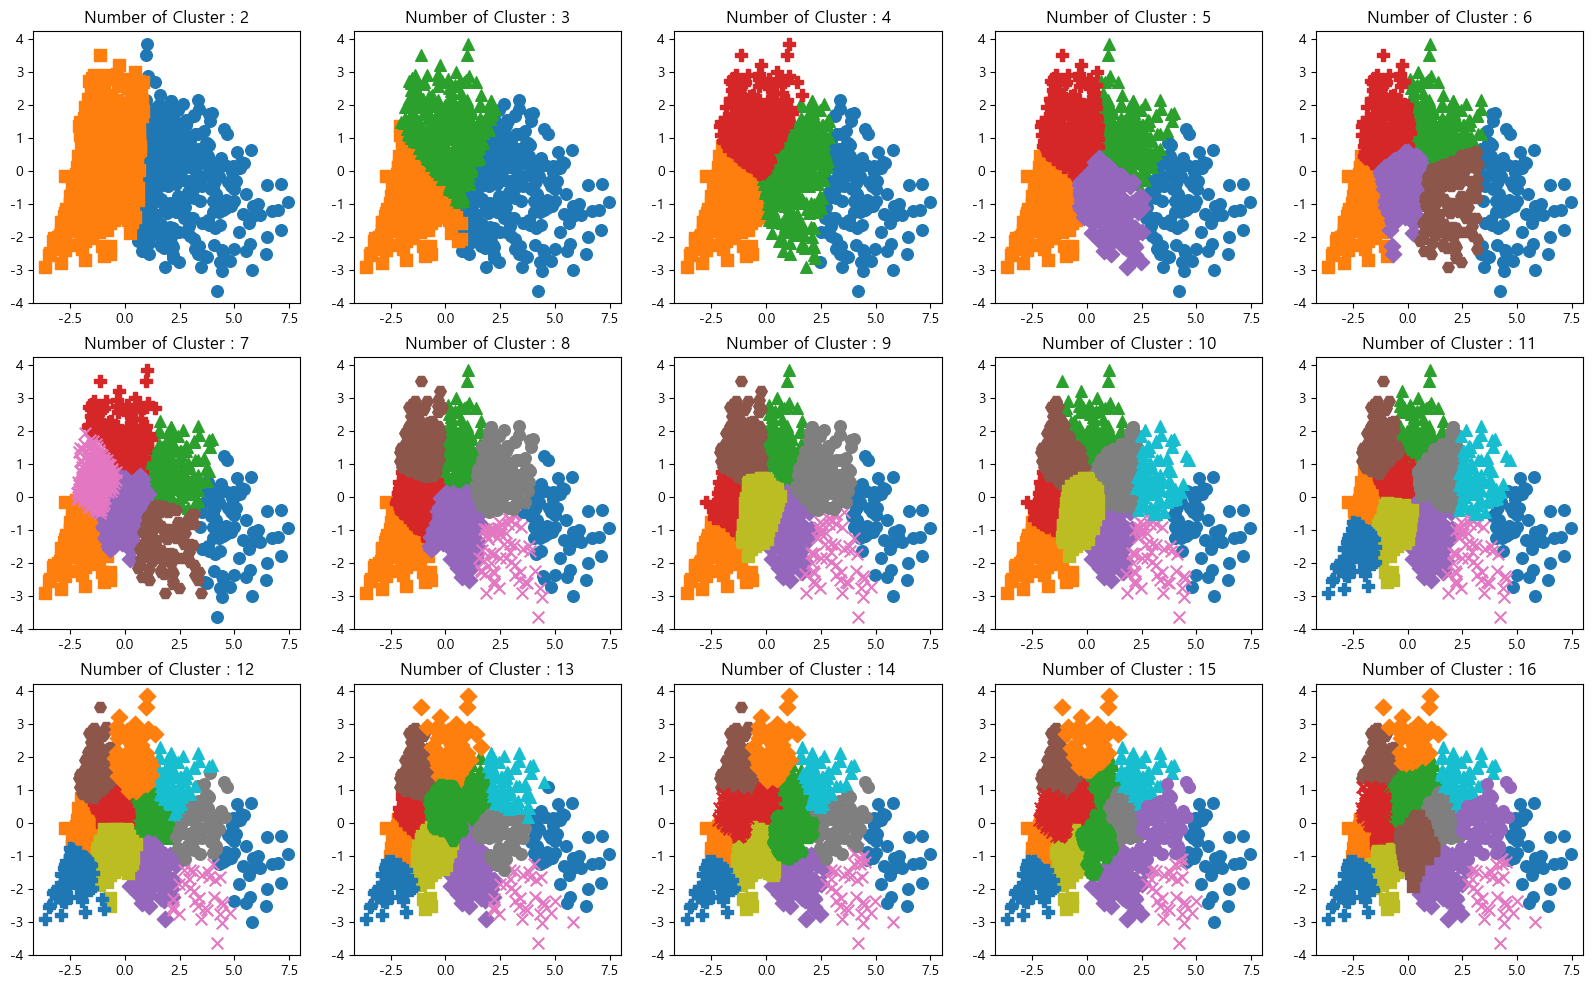

In [170]:
visualize_silhouette(range(2, 17), norm_ss)
visualize_kmeans_plot_multi(range(2, 17),norm_ss)

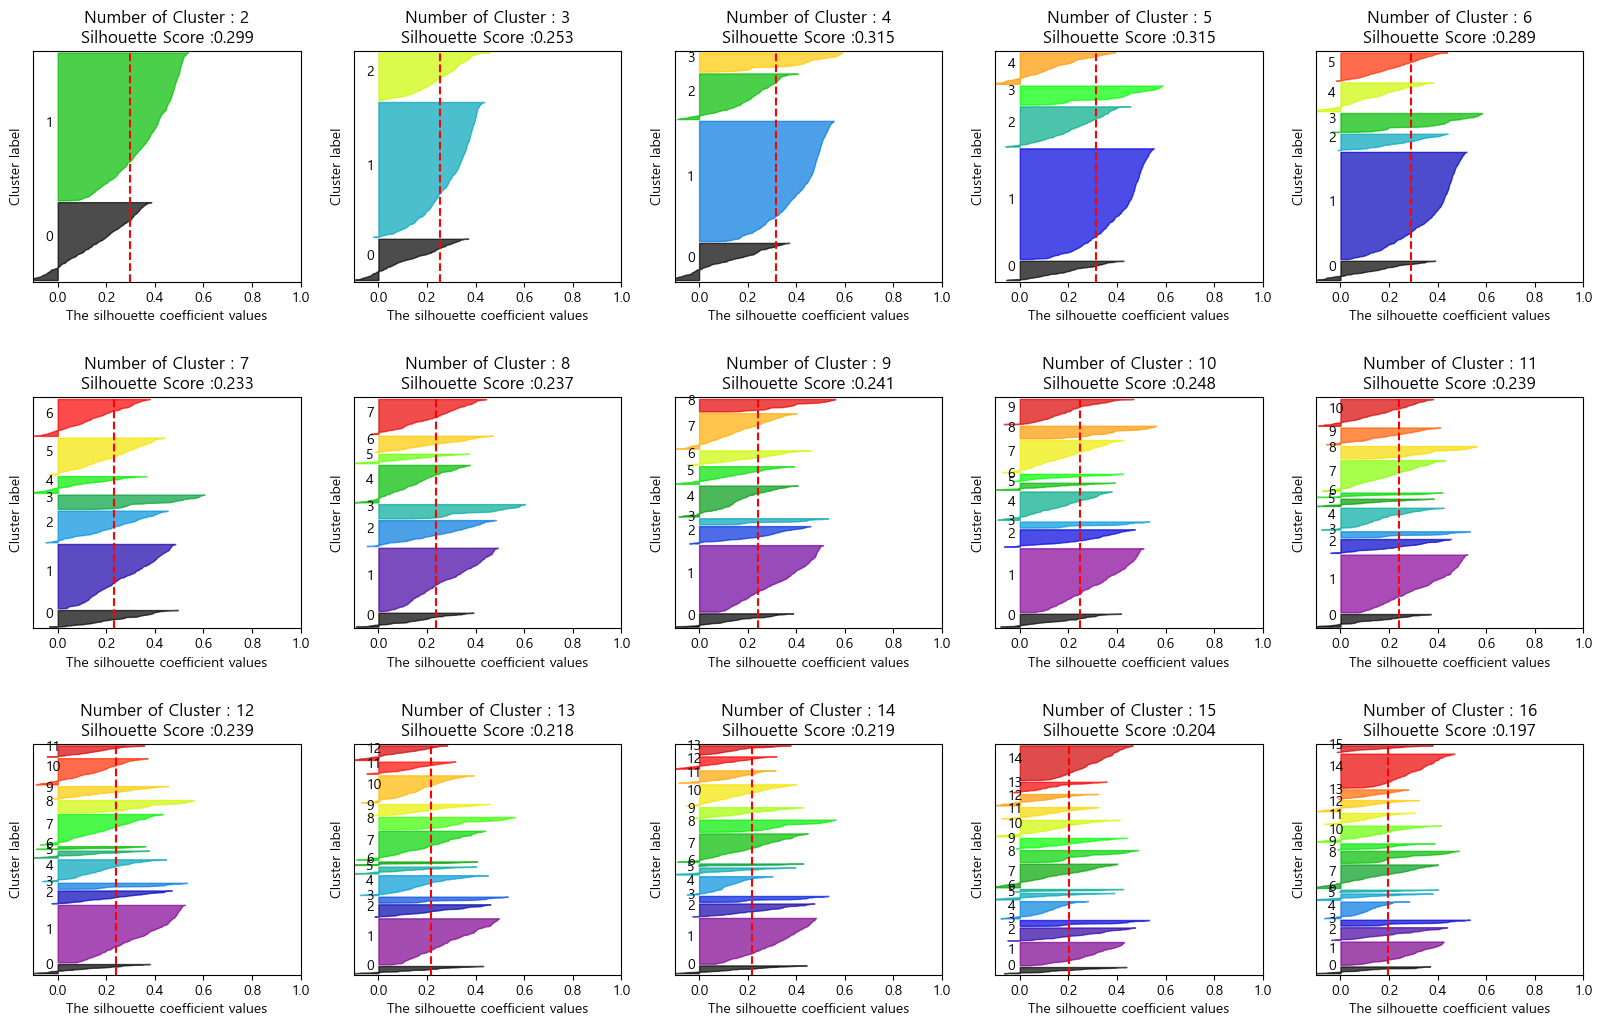

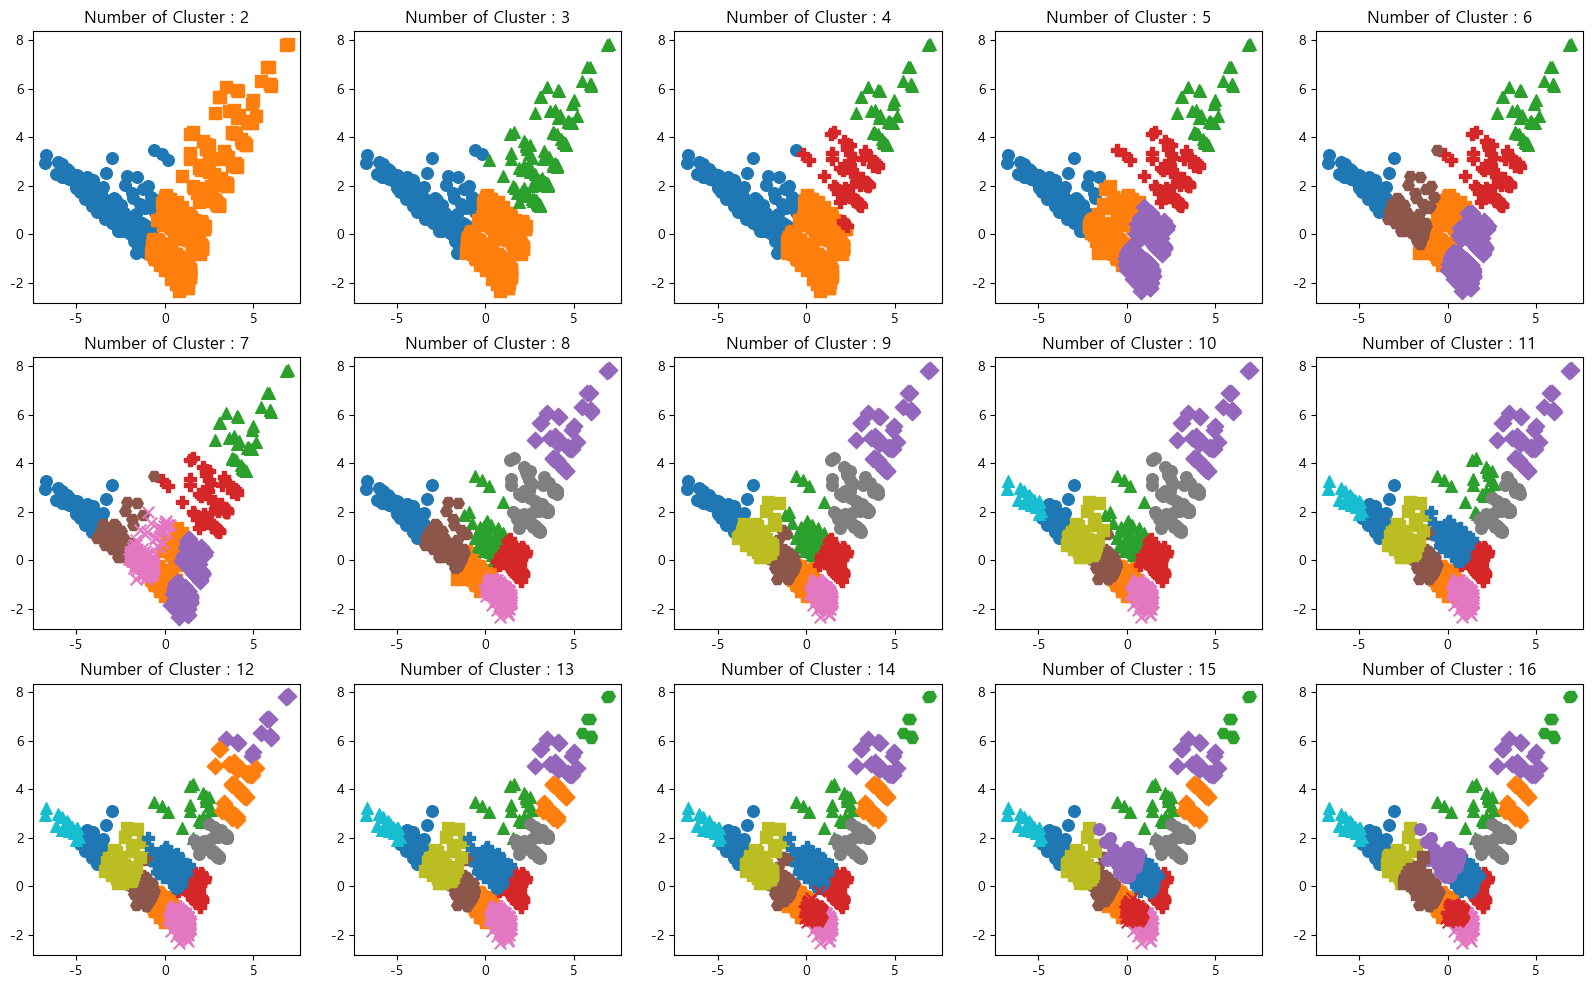

In [171]:
visualize_silhouette(range(2, 17), norm_rs)
visualize_kmeans_plot_multi(range(2, 17),norm_rs)

- 로버스트 스케일러를 사용해 클러스터를 4, 5개로 분리했을 때 실루엣 스코어가 가장 크게 나옴
- 가장 균등하게 나뉘는 건 민맥스 스케일러

In [172]:
out_features = outlier_data.drop('CustomerID', axis=1).copy()

out_ss = StandardScaler().fit_transform(out_features)
out_ms = MinMaxScaler().fit_transform(out_features)
out_rs = RobustScaler().fit_transform(out_features)

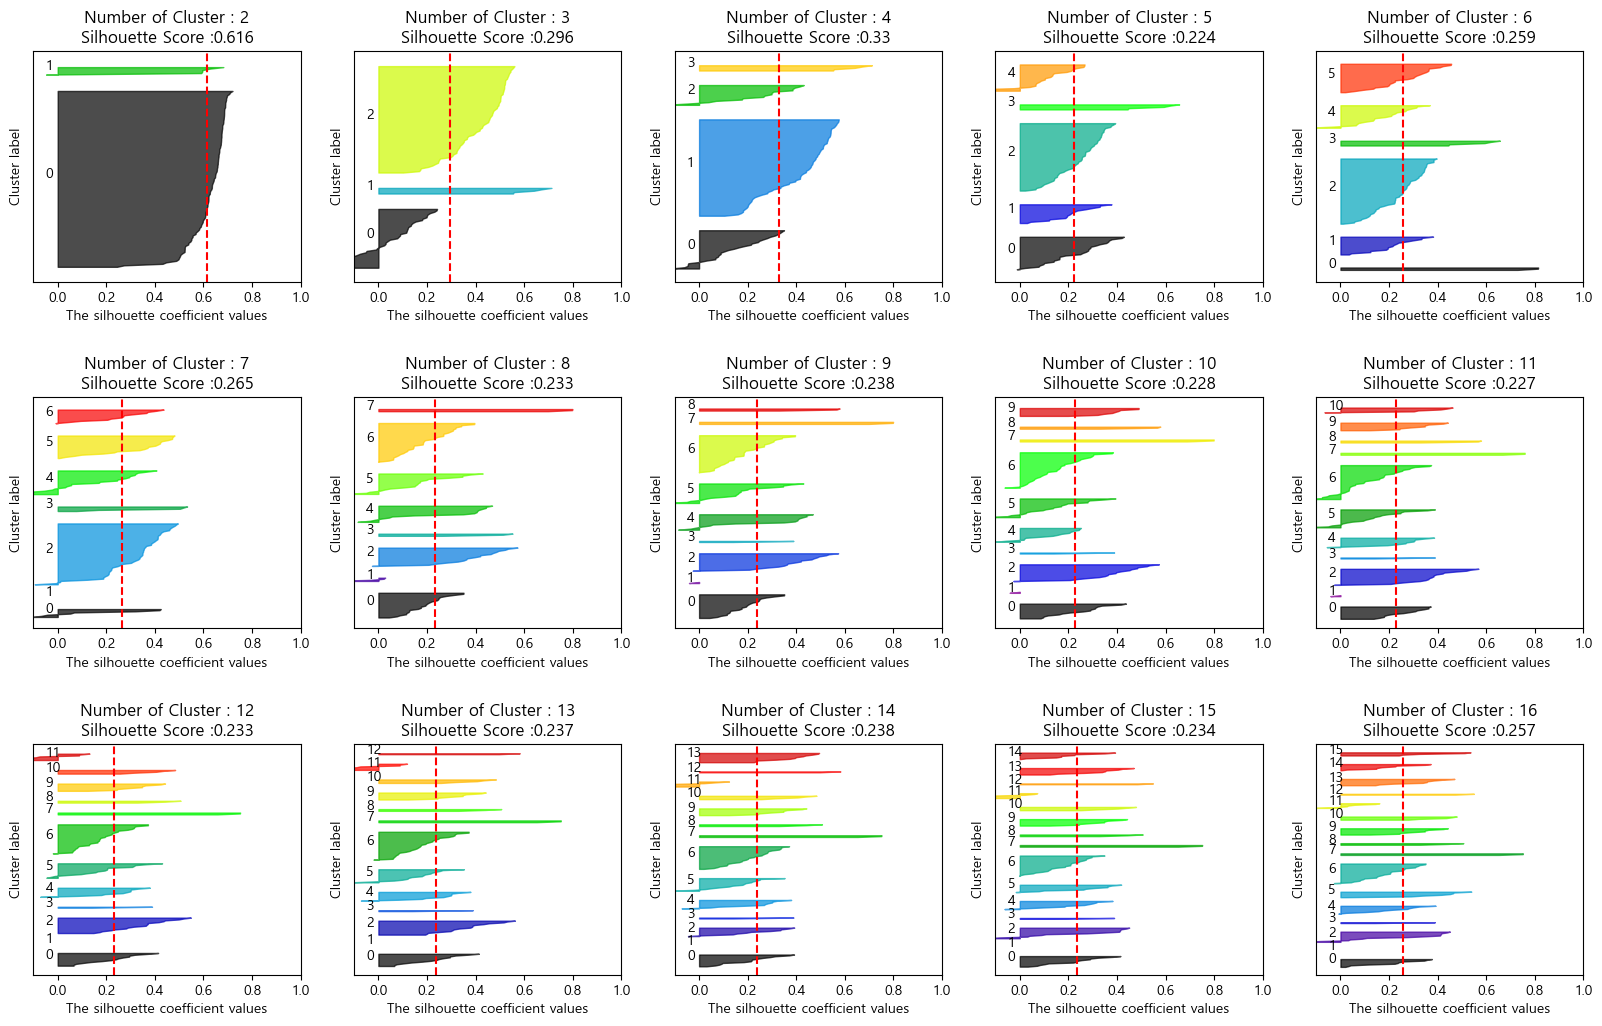

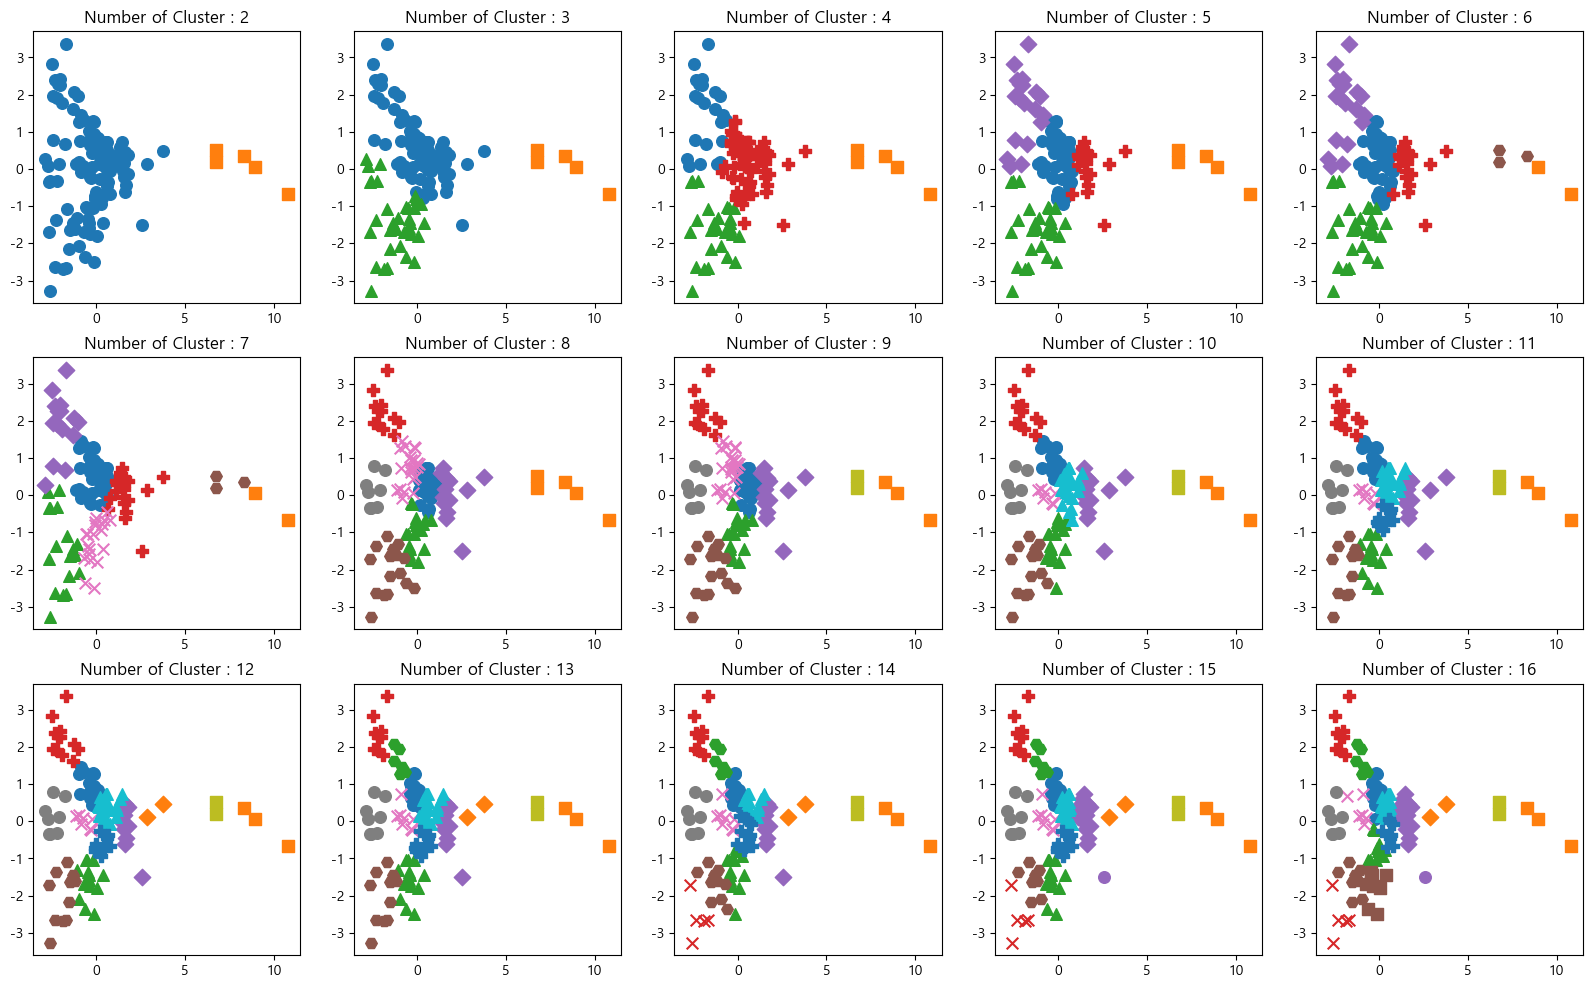

In [173]:
visualize_silhouette(range(2, 17), out_ss)
visualize_kmeans_plot_multi(range(2, 17),out_ss)

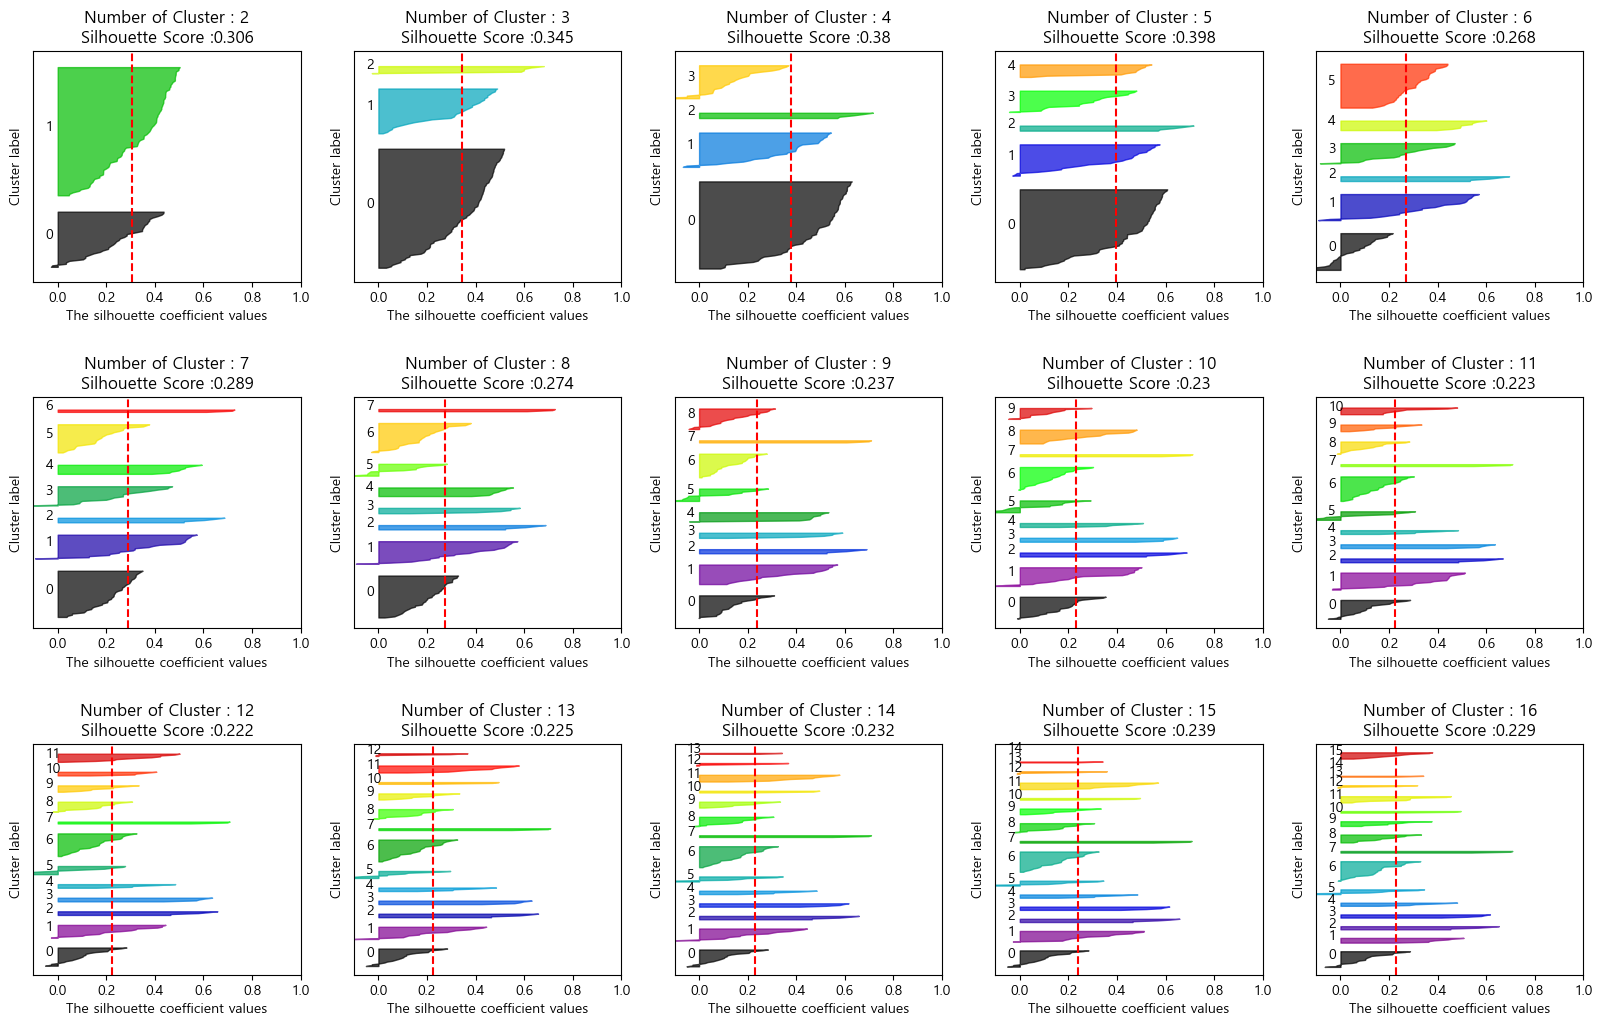

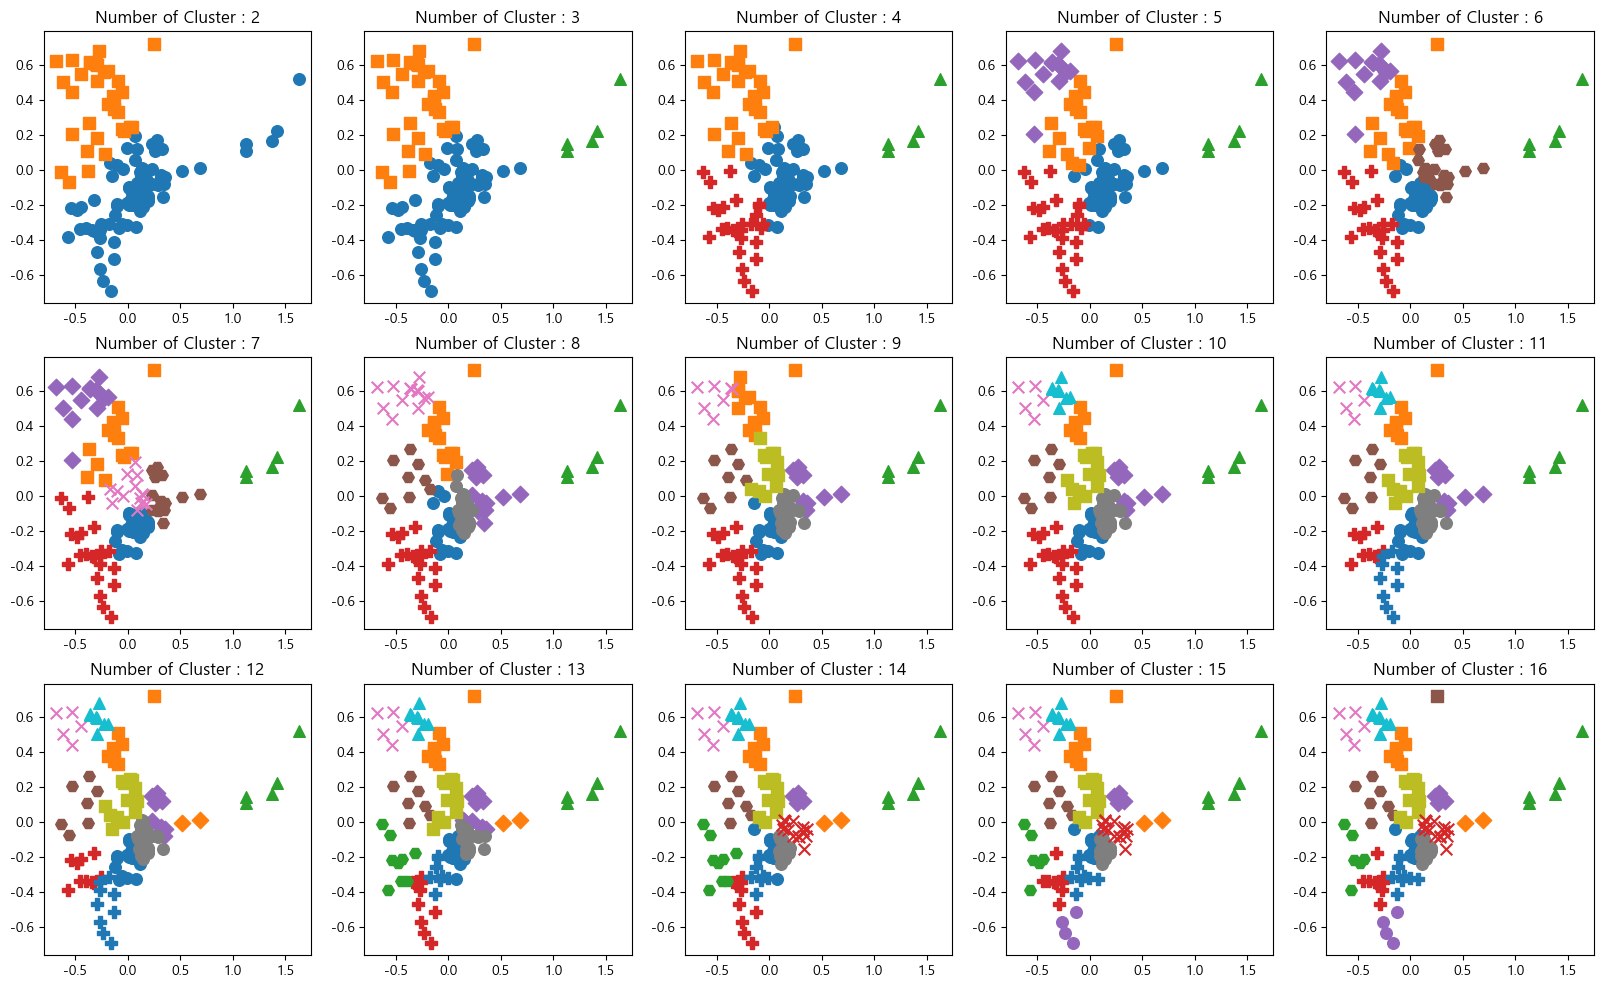

In [174]:
visualize_silhouette(range(2, 17), out_ms)
visualize_kmeans_plot_multi(range(2, 17),out_ms)

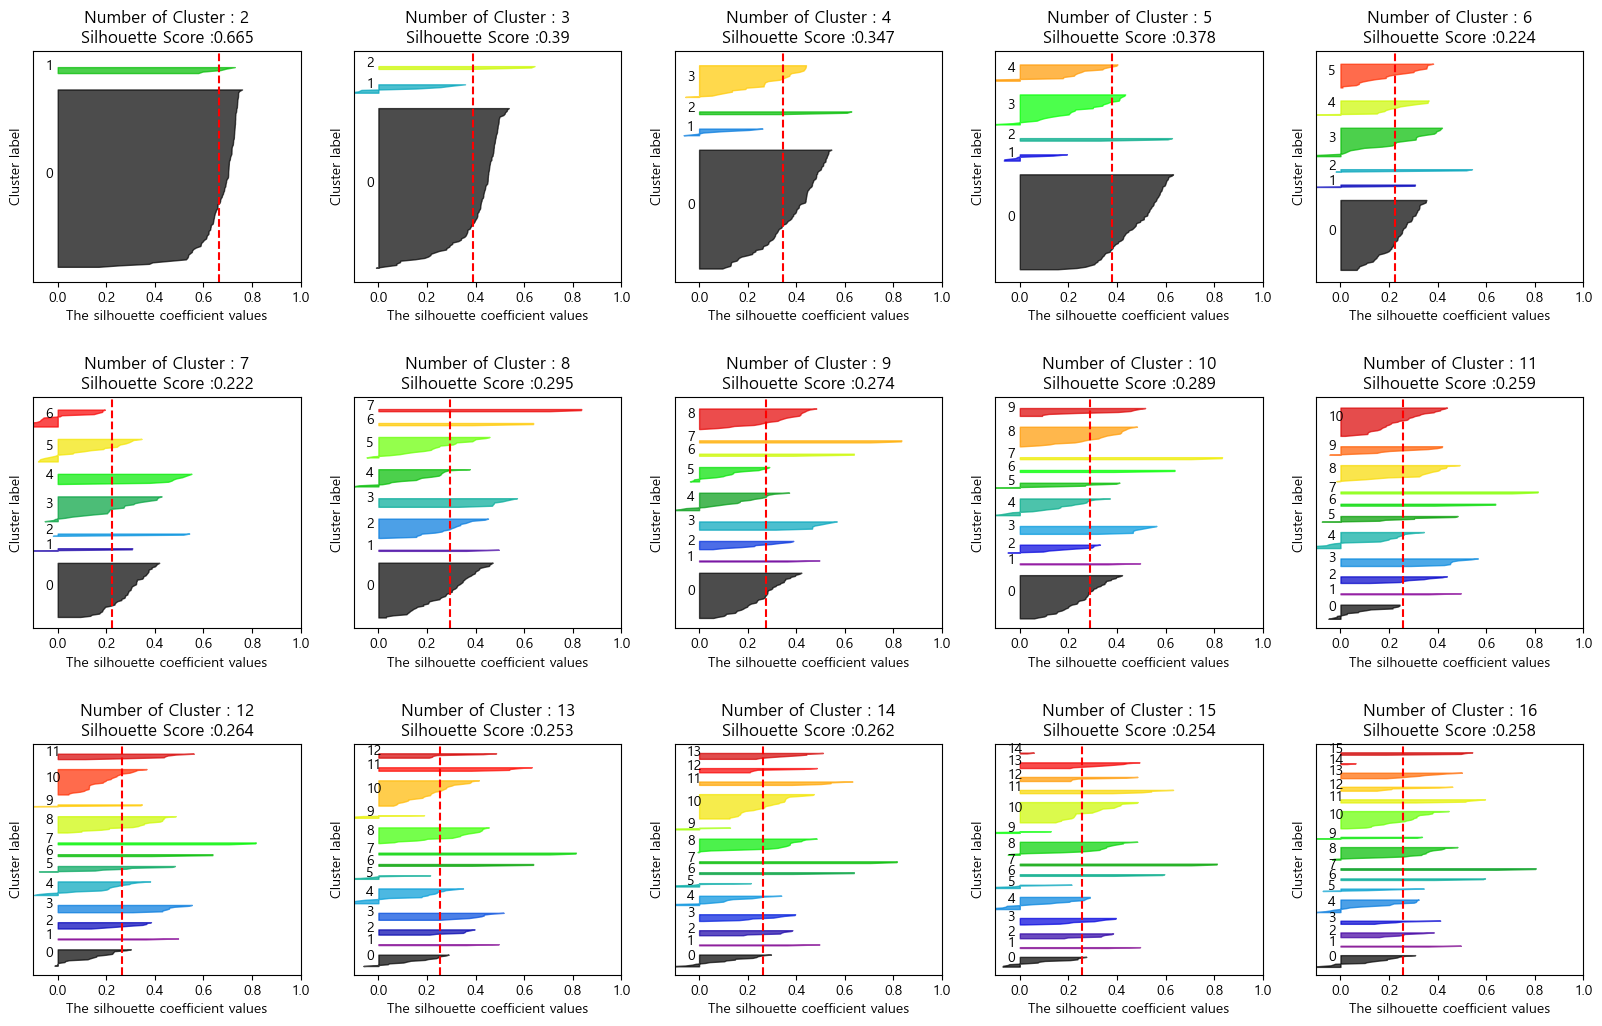

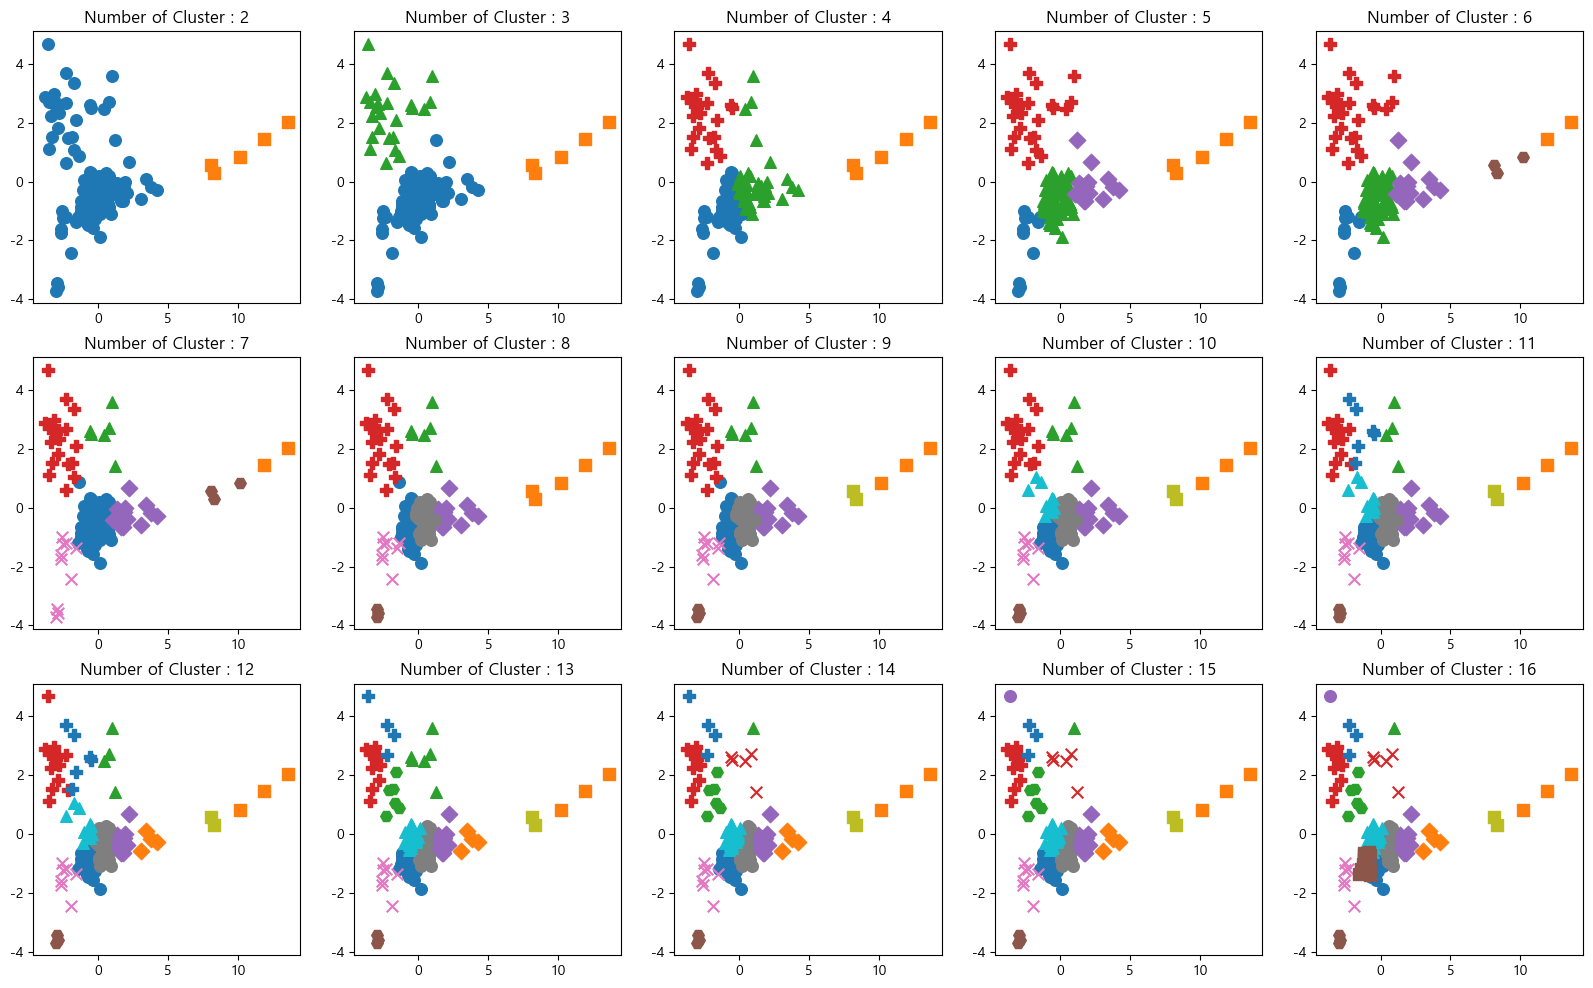

In [175]:
visualize_silhouette(range(2, 17), out_rs)
visualize_kmeans_plot_multi(range(2, 17),out_rs)

- 이상치 데이터는 로버스트 스케일러를 사용해 2개 클러스터로 분리하는게 적당해 보임
    - 일부 저지출 고객과 다수의 대량 지출 고객

### DBSCAN 적용

In [185]:
eps_values = np.arange(0.1, 0.5, 0.01) 
min_samples_values = range(3, 20) 
grid_search_parameter(norm_ss, eps_values, min_samples_values)

Best Score: -0.12496600295640087, EPS: 0.45999999999999985, min_samples: 12


In [186]:
grid_search_parameter(norm_ms, eps_values, min_samples_values)

Best Score: 0.3239506047918658, EPS: 0.30999999999999994, min_samples: 6


In [187]:
grid_search_parameter(norm_rs, eps_values, min_samples_values)

Best Score: -0.04382660125639415, EPS: 0.48999999999999977, min_samples: 6


실루엣 스코어: 0.3239506047918658
[-1  0  1]


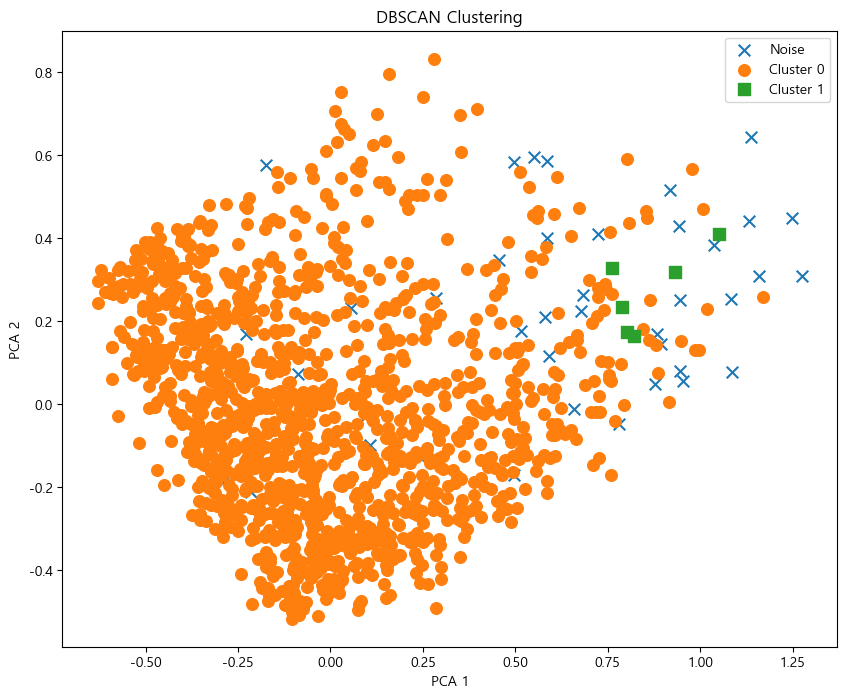

In [188]:
get_cluster_by_dbscan(norm_ms, 0.31, 6)

- 정상데이터에 대해 dbscan 적용시, 민맥스 스케일러로 2개 클러스터일 때 실루엣 스코어가 0.32로 가장 높게 나타남
- 하지만 노이즈 제외, 1개 클러스터가 6명 제외 나머지가 하나의 클러스터로 묶여서 큰 의미가 없음

### GMM 적용

실루엣 스코어: 0.08920078727751045


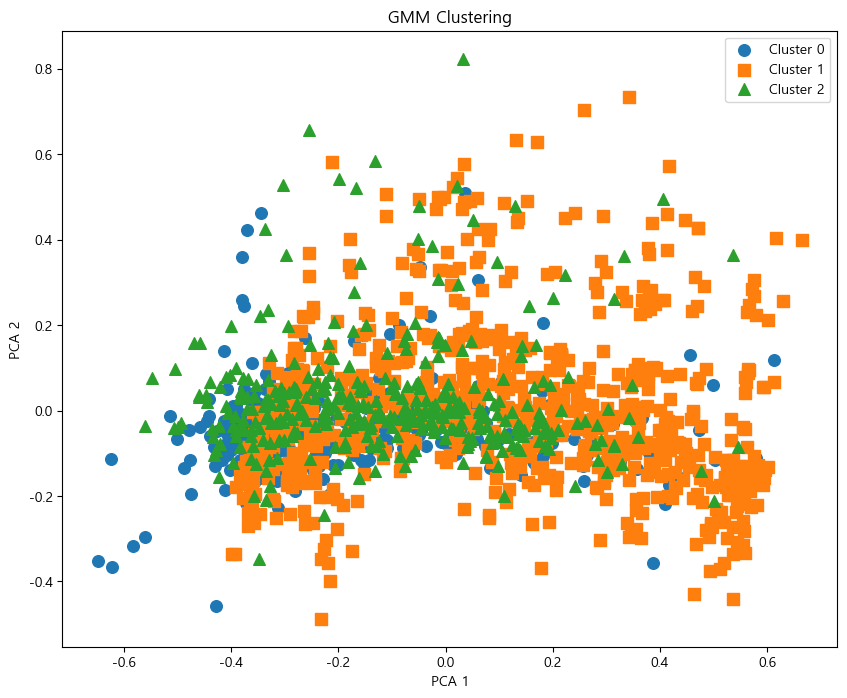

In [189]:
from sklearn.mixture import GaussianMixture

def get_cluster_by_gmm(input, n_components, covariance_type='full'):
    X = input
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    gmm.fit(X)
    cluster_labels = gmm.predict(X)
    
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    dataframe['cluster'] = cluster_labels
    
    if len(np.unique(cluster_labels)) > 1:
        sil_score = silhouette_score(X, cluster_labels)
        print("실루엣 스코어:", sil_score)
    else:
        print("유효한 클러스터가 없습니다.")
    
    unique_labels = np.unique(cluster_labels)
    fig, axs = plt.subplots(figsize=(10, 8))
    markers=['o', 's', '^', 'P', 'D', 'H', 'x']
    
    for label in unique_labels:
        label_df = dataframe[dataframe['cluster'] == label]
        cluster_legend = 'Cluster '+str(label)
        axs.scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70, marker=markers[label % len(markers)], label=cluster_legend)
    
    plt.title('GMM Clustering')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(loc='upper right')
    plt.show()


get_cluster_by_gmm(features_ms, n_components=3, covariance_type='full')

In [190]:
from sklearn.mixture import GaussianMixture

def find_optimal_components_by_gmm(input, n_components, covariance_type='full'):
    X = input
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    gmm.fit(X)
    cluster_labels = gmm.predict(X)
    
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    dataframe['cluster'] = cluster_labels
    
    print('n_components : ', n_components)
    
    if len(np.unique(cluster_labels)) > 1:
        sil_score = silhouette_score(X, cluster_labels)
        print("실루엣 스코어:", sil_score)
    else:
        print("유효한 클러스터가 없습니다.")
    
    unique_labels = np.unique(cluster_labels)
    print('Cluster labels : ', unique_labels)
    print('*'*50)

for n in range(3, 12):
    find_optimal_components_by_gmm(features_ms, n_components=n, covariance_type='full')

n_components :  3
실루엣 스코어: 0.08934994521794898
Cluster labels :  [0 1 2]
**************************************************
n_components :  4
실루엣 스코어: 0.06742045111084576
Cluster labels :  [0 1 2 3]
**************************************************
n_components :  5
실루엣 스코어: 0.04153731454263374
Cluster labels :  [0 1 2 3 4]
**************************************************
n_components :  6
실루엣 스코어: 0.06066126578384354
Cluster labels :  [0 1 2 3 4 5]
**************************************************
n_components :  7
실루엣 스코어: 0.03708532436283704
Cluster labels :  [0 1 2 3 4 5 6]
**************************************************
n_components :  8
실루엣 스코어: 0.021782517775623
Cluster labels :  [0 1 2 3 4 5 6 7]
**************************************************
n_components :  9
실루엣 스코어: -0.012078710099666332
Cluster labels :  [0 1 2 3 4 5 6 7 8]
**************************************************
n_components :  10
실루엣 스코어: -0.010063967526137406
Cluster labels :  [0 1 2 3 4 5 6 7 8 9]


- GMM 적용시, 실루엣 스코어를 기준으로 살펴보면 유의미한 클러스터를 찾을 수 없음

## 결론

- 클러스터 숫자가 2보다 컸고 실루엣 스코어가 0.3 이상이었던 케이스
    - 정상데이터에 대해 로버스트 스케일러를 적용하여 Kmeans를 이용해 클러스터링

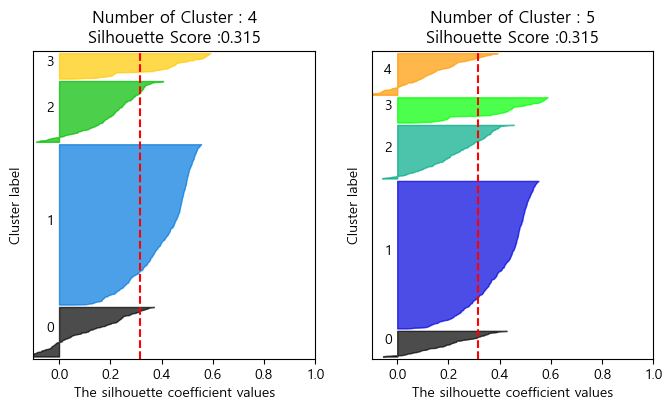

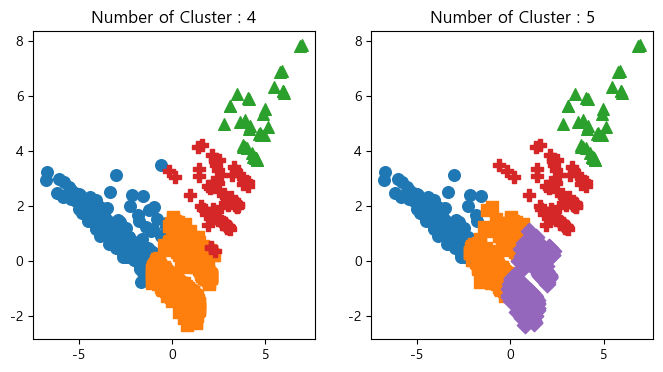

In [191]:
visualize_silhouette(range(4, 6), norm_rs)
visualize_kmeans_plot_multi(range(4, 6),norm_rs)

In [193]:
inertia_arr = []
k_range = range(3, 7)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(norm_rs)
    inertia = kmeans.inertia_
    
    print(f'K : {k}, inertia: {inertia}')
    inertia_arr.append(inertia)

K : 3, inertia: 8433.699848543018
K : 4, inertia: 6089.066785644678
K : 5, inertia: 5357.361191294402
K : 6, inertia: 5024.731875626669


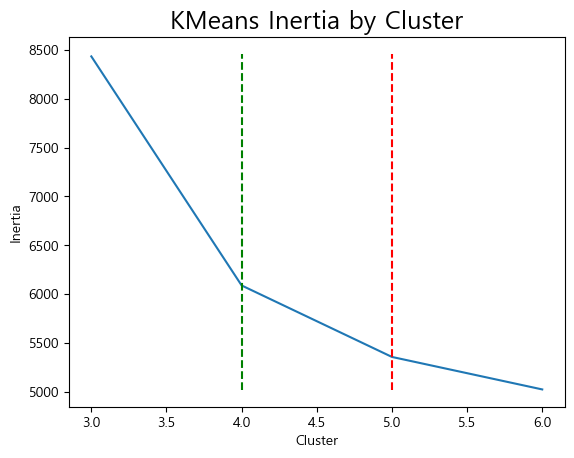

In [197]:
plt.plot(k_range, inertia_arr)
plt.vlines(4, ymin=min(inertia_arr)*0.999, ymax=max(inertia_arr)*1.003, linestyles='--', colors='g')
plt.vlines(5, ymin=min(inertia_arr)*0.999, ymax=max(inertia_arr)*1.003, linestyles='--', colors='r')
plt.title('KMeans Inertia by Cluster', fontsize=18)
plt.xlabel('Cluster')
plt.ylabel('Inertia')
plt.show()

- 실루엣 스코어로 보거나 엘보우 메소드를 사용한 결과, 4 혹은 5로 클러스터를 정하는 것이 좋아 보임

In [199]:
del df_input['Cluster']

In [204]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_4 = kmeans.fit_predict(norm_rs)
normal_data['Cluster_4'] = cluster_4
normal_data

CustomerID  구매건수  평균구매간격  구매발생일수  Recency  총구매수량   구입상품_평균가격     총지출액  \
0     USER_0000     1     0.0       1      108      3   12.745000    30.99   
2     USER_0002     8   119.0       2       74    209   14.631304  1442.12   
3     USER_0003    11     0.0       1       18     21   77.200000  1360.07   
4     USER_0004    13     0.0       1      108     56   34.578611  1442.47   
5     USER_0005     3     0.0       1      131     86   14.713125   601.81   
...         ...   ...     ...     ...      ...    ...         ...      ...   
1463  USER_1463     3     0.0       1      271     46   12.104286   544.34   
1464  USER_1464    19    52.5       3       88    141   27.872250  2363.05   
1465  USER_1465     2    76.0       2      195     10   11.167500   101.56   
1466  USER_1466     1     0.0       1       70      2  149.000000   298.00   
1467  USER_1467    53    73.0       2       83    155   55.470588  6362.77   

      구매제품_종류  최대지출_카테고리_인코딩  Cluster_4  
0           2              2          1  
2          21              1          2  
3          11              1          1  
4          33              1          1  
5          16              2          1  
...       ...            ...        ...  
1463        7              8          3  
1464       35              1          2  
1465        8              2          1  
1466        1              1          1  
1467       69              1          0  

[1343 rows x 11 columns]

In [205]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
cluster_5 = kmeans.fit_predict(norm_rs)
normal_data['Cluster_5'] = cluster_5
normal_data

CustomerID  구매건수  평균구매간격  구매발생일수  Recency  총구매수량   구입상품_평균가격     총지출액  \
0     USER_0000     1     0.0       1      108      3   12.745000    30.99   
2     USER_0002     8   119.0       2       74    209   14.631304  1442.12   
3     USER_0003    11     0.0       1       18     21   77.200000  1360.07   
4     USER_0004    13     0.0       1      108     56   34.578611  1442.47   
5     USER_0005     3     0.0       1      131     86   14.713125   601.81   
...         ...   ...     ...     ...      ...    ...         ...      ...   
1463  USER_1463     3     0.0       1      271     46   12.104286   544.34   
1464  USER_1464    19    52.5       3       88    141   27.872250  2363.05   
1465  USER_1465     2    76.0       2      195     10   11.167500   101.56   
1466  USER_1466     1     0.0       1       70      2  149.000000   298.00   
1467  USER_1467    53    73.0       2       83    155   55.470588  6362.77   

      구매제품_종류  최대지출_카테고리_인코딩  Cluster_4  Cluster_5  
0           2              2          1          1  
2          21              1          2          2  
3          11              1          1          1  
4          33              1          1          1  
5          16              2          1          1  
...       ...            ...        ...        ...  
1463        7              8          3          3  
1464       35              1          2          2  
1465        8              2          1          2  
1466        1              1          1          1  
1467       69              1          0          4  

[1343 rows x 12 columns]

In [210]:
normal_data.drop(['Cluster_5', 'CustomerID'], axis=1).groupby('Cluster_4', as_index=False).mean()

Cluster_4       구매건수     평균구매간격    구매발생일수     Recency       총구매수량  \
0          0  34.675556  40.759556  3.040000  122.755556  324.351111   
1          1   8.913223   2.918733  1.207989  170.931129   52.876033   
2          2  14.750000  99.025168  3.068841  101.105072   84.536232   
3          3   3.629310   8.469828  1.163793  181.732759   73.181034   

   구입상품_평균가격         총지출액    구매제품_종류  최대지출_카테고리_인코딩  
0  53.287562  6019.258489  48.915556       1.106667  
1  56.562743  1423.565262  13.865014       1.345730  
2  52.120921  2237.029384  23.054348       1.166667  
3  18.944939   614.071638   7.827586       6.060345

In [211]:
normal_data.drop(['Cluster_4', 'CustomerID'], axis=1).groupby('Cluster_5', as_index=False).mean()

Cluster_5       구매건수      평균구매간격    구매발생일수     Recency       총구매수량  \
0          0  34.440678   57.815506  5.042373   72.635593  225.025424   
1          1   7.835067    2.557949  1.202080  170.588410   42.705795   
2          2  13.897959  106.914082  2.706122  106.355102   81.559184   
3          3   3.629310    8.469828  1.163793  181.732759   73.181034   
4          4  29.329843   20.330716  1.785340  158.047120  311.115183   

   구입상품_평균가격         총지출액    구매제품_종류  최대지출_카테고리_인코딩  
0  53.475377  5412.894915  48.127119       1.033898  
1  56.980755  1244.131218  12.453195       1.353640  
2  51.180288  2123.358286  22.220408       1.175510  
3  18.944939   614.071638   7.827586       6.060345  
4  53.624678  5282.811309  41.523560       1.188482

- 4개, 5개 모두 클러스터 별 차이는 뚜렷해 보임
- 5개 클러스터일 때 Recency의 차이가 더 드러나는 걸로 보여 클러스터 5로 결정

- **0번 클러스터 : 충성 고객 그룹**
    - 총지출액이 가장 크고, 구매건수도 가장 많음. 가장 최근에 구매한 기록이 있음. 
    - 가장 다양한 종류의 상품을 구매하며, Nest-USA 제품에 가장 많은 돈을 지출
    - 구매가 단발성이 아님. 구매발생일이 5일로 클러스터 중 가장 높음.
    - 가장 충성도가 높은 고객그룹
- **1번 클러스터 : 목적지향 고객 그룹**
    - 총지출액이 적고, 구매수량도 적음. 구매제품의 종류도 비교적 적음
    - 구매를 한 기록이 오래되었음
    - 특정 목적을 위해 구매를 했던 것으로 추정
- **2번 클러스터 : 비정기 대량 구매 그룹**
    - 평균 구매간격이 가장 긴 편. 구매발생일 평균은 2.7로 일정 기간 동안 구매가 이뤄짐.
    - 총지출액이나 구매건수가 중간 수준
    - 비정기적으로 큰 구매를 하는 패턴일 수 있음
    - Recency도 2번째로 낮은 편
    - 특별한 경우에 구매를 하고 구매시엔 비교적 많은 금액을 지출
- **3번 클러스터 : 일회성 구매 그룹**
    - 구매건수가 가장 적고, 총지출액도 가장 적음.
    - 구매발생일이 가장 적고 Recency가 가장 큼.
    - 1회 방문하여 소액 구매 후 비활성화된 고객.
    - 다른 클러스터와 달리 Nest-USA 지출 비중이 낮음. 다른 클러스터와 관심 품목 카테고리가 다를 것
- **4번 클러스터 : 잠재적 충성 고객 그룹**
    - 총지출액이 2번째로 많음. 구매건수도 2번째
    - 구매수량도 많고, 구매제품 종류도 많음
    - 0번 클러스터와 비교해서 구매발생일이 크게 낮음
    - 다양한 상품에 대해 높은 구매력을 가진 고객
    - 총지출액의 차이가 크지 않지만, Recency, 구매발생일의 차이로 보아 0번 클러스터에 비해 상대적으로 충성도가 떨어진다고 볼 수 있음